In [1]:
import librosa
import numpy as np
import os
import soundfile as sf

# Función para dividir el audio en fragmentos con posible canto de aves
def dividir_audio_canto(archivo_entrada, duracion_fragmento_segundos, umbral_energia, ruta_salida):
    audio, sr = librosa.load(archivo_entrada, sr=None, mono=True)
    
    frame_length = int(duracion_fragmento_segundos * sr)
    hop_length = frame_length  # Fragmentos sin solapamiento

    energia = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length)[0]

    if not os.path.exists(ruta_salida):
        os.makedirs(ruta_salida)

    fragmentos = []
    for i, e in enumerate(energia):
        if e > umbral_energia:
            start_sample = i * hop_length
            end_sample = start_sample + frame_length
            fragmento = audio[start_sample:end_sample]
            archivo_salida = os.path.join(ruta_salida, f"fragmento_{i + 1}.wav")
            sf.write(archivo_salida, fragmento, sr)
            fragmentos.append(archivo_salida)

    return fragmentos

# Parámetros
archivo_entrada = r"C:\Users\JOINER PEREZ\Downloads\audio 2 (mp3cut.net) (1).wav"
ruta_salida = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos"
umbral_energia = 0.05
duracion_fragmento_segundos = 5

# Ejecutar Bloque 1
fragmentos = dividir_audio_canto(archivo_entrada, duracion_fragmento_segundos, umbral_energia, ruta_salida)
print(f"Fragmentos guardados en: {ruta_salida}")


Fragmentos guardados en: C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos


In [15]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd

# Cargar el modelo YAMNet desde TensorFlow Hub
modelo = hub.load("https://tfhub.dev/google/yamnet/1")

# Cargar el mapeo de clases de YAMNet
class_map_path = tf.keras.utils.get_file(
    'yamnet_class_map.csv',
    'https://storage.googleapis.com/audioset/yamnet_class_map.csv'
)
class_map = pd.read_csv(class_map_path)


In [16]:
import os
import shutil
import librosa
import numpy as np
import tensorflow as tf

# Función para obtener el nombre de la clase a partir del índice
def obtener_nombre_clase(indice, class_map):
    if 0 <= indice < len(class_map):
        return class_map.iloc[indice]['display_name']
    else:
        return "Clase desconocida"

# Función para clasificar audio con YAMNet
def clasificar_audio_yamnet(archivo_audio, modelo):
    """
    Carga un archivo de audio, lo convierte a float32, 
    lo rellena si es muy corto y luego se clasifica con YAMNet.
    Devuelve (class_index, class_score).
    """
    # 1. Cargar y forzar sample rate = 16 kHz (YAMNet lo requiere)
    audio, sr = librosa.load(archivo_audio, sr=16000, mono=True)
    
    # 2. Convertir a float32
    audio = audio.astype(np.float32)
    
    # 3. Rellenar si es muy corto (< 0.975s ~ 15600 muestras)
    min_length = 15600
    if len(audio) < min_length:
        padding = min_length - len(audio)
        audio = np.pad(audio, (0, padding), 'constant')
    
    # 4. Convertir a tensor unidimensional de forma (N,) (NO expand_dims)
    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)  # shape=(N,)
    
    # 5. Inferencia con YAMNet
    #    YAMNet devuelve scores, embeddings y spectrogram
    scores, embeddings, spectrogram = modelo(audio_tensor)
    
    # 6. scores.shape => (num_frames, num_classes). 
    #    Hacer un promedio de scores a lo largo de frames.
    scores_np = scores.numpy()  # Convertir a numpy
    mean_scores = np.mean(scores_np, axis=0)  # shape=(num_classes,)
    
    # 7. Obtener la clase dominante y su puntuación
    class_index = np.argmax(mean_scores)
    class_score = mean_scores[class_index]
    
    return class_index, class_score

# Rutas de los directorios
ruta_fragmentos = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos"
ruta_salida_reales = os.path.join(ruta_fragmentos, "reales")

# Crear la carpeta de salida si no existe
if not os.path.exists(ruta_salida_reales):
    os.makedirs(ruta_salida_reales)

# Índice de la clase "Bird" en el modelo YAMNet
# **Ajusta este valor tras revisar cuál es el índice de "Bird" en tu class_map**
indice_ave = 4  

# Verificar que la carpeta de fragmentos existe y contiene archivos
if not os.path.exists(ruta_fragmentos):
    print(f"❌ La carpeta '{ruta_fragmentos}' no existe. Verifica la ruta.")
else:
    archivos = os.listdir(ruta_fragmentos)
    wav_files = [f for f in archivos if f.endswith('.wav')]
    if not wav_files:
        print(f"❌ La carpeta '{ruta_fragmentos}' no contiene archivos '.wav'.")
    else:
        print(f"✅ Encontrados {len(wav_files)} archivos '.wav' en '{ruta_fragmentos}'. Iniciando clasificación...")

        # Clasificar los fragmentos
        for archivo in wav_files:
            ruta_completa = os.path.join(ruta_fragmentos, archivo)
            try:
                class_index, class_score = clasificar_audio_yamnet(ruta_completa, modelo)
                
                # Obtener el nombre de la clase
                nombre_clase = obtener_nombre_clase(class_index, class_map)
                
                # Comprobar si la clase es "Bird" y el score es mayor al umbral
                if class_index == indice_ave and class_score > 0.5:
                    destino = os.path.join(ruta_salida_reales, archivo)
                    shutil.move(ruta_completa, destino)
                    print(f"✔️ Audio '{archivo}' clasificado como 'Ave' y movido a {ruta_salida_reales} (score={class_score:.2f})")
                else:
                    print(f"🔍 Audio '{archivo}' clasificado como '{nombre_clase}' (score={class_score:.2f})")
            
            except Exception as e:
                print(f"⚠️ Error al procesar el archivo '{archivo}': {e}")


✅ Encontrados 2345 archivos '.wav' en 'C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos'. Iniciando clasificación...
🔍 Audio 'fragmento_1.wav' clasificado como 'Insect' (score=0.42)
🔍 Audio 'fragmento_10.wav' clasificado como 'Animal' (score=0.34)
🔍 Audio 'fragmento_100.wav' clasificado como 'Vehicle' (score=0.10)
🔍 Audio 'fragmento_1009.wav' clasificado como 'Insect' (score=0.35)
🔍 Audio 'fragmento_101.wav' clasificado como 'Insect' (score=0.19)
🔍 Audio 'fragmento_1017.wav' clasificado como 'Outside, rural or natural' (score=0.20)
🔍 Audio 'fragmento_1019.wav' clasificado como 'Animal' (score=0.26)
🔍 Audio 'fragmento_102.wav' clasificado como 'Insect' (score=0.28)
🔍 Audio 'fragmento_1020.wav' clasificado como 'Animal' (score=0.30)
🔍 Audio 'fragmento_1021.wav' clasificado como 'Animal' (score=0.34)
🔍 Audio 'fragmento_1022.wav' clasificado como 'Animal' (score=0.30)
🔍 Audio 'fragmento_1024.wav' clasificado como 'Animal' (score=0.37)
🔍 Audio 'fragmento_1028.wav' clasificado como 'Anima

In [56]:
import os
import shutil
import librosa
import numpy as np
import tensorflow as tf

# Rutas de los directorios
ruta_fragmentos = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos"
ruta_salida_seleccionados = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos seleccionados"

# Crear la carpeta de salida si no existe
if not os.path.exists(ruta_salida_seleccionados):
    os.makedirs(ruta_salida_seleccionados)

# Lista de categorías de interés
categorias_interes = [
    "Wild animals",
    "Bird vocalization, bird call, bird song",
    "Music",
    "Buzz",
    "Drill"
]

indice_ave = 4  # Ajustar según el modelo YAMNet

def obtener_nombre_clase(indice, class_map):
    if 0 <= indice < len(class_map):
        return class_map.iloc[indice]['display_name']
    else:
        return "Clase desconocida"

def clasificar_audio_yamnet(archivo_audio, modelo):
    """
    Clasifica un archivo de audio usando YAMNet.
    Retorna (class_index, class_score).
    """
    audio, sr = librosa.load(archivo_audio, sr=16000, mono=True)
    audio = audio.astype(np.float32)
    min_length = 15600
    if len(audio) < min_length:
        audio = np.pad(audio, (0, min_length - len(audio)), 'constant')
    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)
    scores, _, _ = modelo(audio_tensor)
    mean_scores = np.mean(scores.numpy(), axis=0)
    class_index = np.argmax(mean_scores)
    class_score = mean_scores[class_index]
    return class_index, class_score

if not os.path.exists(ruta_fragmentos):
    print(f"❌ La carpeta '{ruta_fragmentos}' no existe.")
else:
    archivos = os.listdir(ruta_fragmentos)
    wav_files = [f for f in archivos if f.endswith('.wav')]
    if not wav_files:
        print(f"❌ No se encontraron archivos '.wav' en '{ruta_fragmentos}'.")
    else:
        print(f"✅ {len(wav_files)} archivos '.wav' encontrados. Iniciando clasificación...")
        for archivo in wav_files:
            ruta_completa = os.path.join(ruta_fragmentos, archivo)
            try:
                class_index, class_score = clasificar_audio_yamnet(ruta_completa, modelo)
                nombre_clase = obtener_nombre_clase(class_index, class_map)
                if class_index == indice_ave and class_score > 0.5 or nombre_clase in categorias_interes:
                    destino = os.path.join(ruta_salida_seleccionados, archivo)
                    shutil.move(ruta_completa, destino)
                    print(f"✔️ '{archivo}' => '{nombre_clase}' movido a '{ruta_salida_seleccionados}' (score={class_score:.2f})")
                else:
                    print(f"🔍 '{archivo}' => '{nombre_clase}' (score={class_score:.2f}) (no se mueve)")
            except Exception as e:
                print(f"⚠️ Error al procesar '{archivo}': {e}")


✅ 2345 archivos '.wav' encontrados. Iniciando clasificación...
🔍 'fragmento_1.wav' => 'Insect' (score=0.42) (no se mueve)
🔍 'fragmento_10.wav' => 'Animal' (score=0.34) (no se mueve)
🔍 'fragmento_100.wav' => 'Vehicle' (score=0.10) (no se mueve)
🔍 'fragmento_1009.wav' => 'Insect' (score=0.35) (no se mueve)
🔍 'fragmento_101.wav' => 'Insect' (score=0.19) (no se mueve)
🔍 'fragmento_1017.wav' => 'Outside, rural or natural' (score=0.20) (no se mueve)
🔍 'fragmento_1019.wav' => 'Animal' (score=0.26) (no se mueve)
🔍 'fragmento_102.wav' => 'Insect' (score=0.28) (no se mueve)
🔍 'fragmento_1020.wav' => 'Animal' (score=0.30) (no se mueve)
🔍 'fragmento_1021.wav' => 'Animal' (score=0.34) (no se mueve)
🔍 'fragmento_1022.wav' => 'Animal' (score=0.30) (no se mueve)
🔍 'fragmento_1024.wav' => 'Animal' (score=0.37) (no se mueve)
🔍 'fragmento_1028.wav' => 'Animal' (score=0.28) (no se mueve)
🔍 'fragmento_1029.wav' => 'Animal' (score=0.30) (no se mueve)
🔍 'fragmento_103.wav' => 'Aircraft' (score=0.25) (no se m

In [58]:
import os
import librosa
import numpy as np
import soundfile as sf
import scipy.signal as signal

# 1. Filtro Pasa-Banda (Butterworth)
def bandpass_filter(audio, sr, lowcut=1500, highcut=8000, order=4):
    """
    Aplica un filtro pasa-banda Butterworth a 'audio'.
    - audio  : array 1D de la señal.
    - sr     : frecuencia de muestreo (int).
    - lowcut, highcut : frecuencias de corte en Hz.
    - order  : orden del filtro Butterworth.
    Retorna la señal filtrada.
    """
    nyquist = 0.5 * sr
    low  = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered = signal.filtfilt(b, a, audio)
    return filtered

# 2. Filtro de Kalman
def filtro_kalman(audio_fragmento, Q=1e-5, R=0.1):
    """
    Aplica un filtro Kalman 1D simple a 'audio_fragmento'.
    - Q : Ruido del proceso
    - R : Ruido de medición
    Ajusta Q y R para permitir más/menos variaciones en la señal.
    """
    n_iter = len(audio_fragmento)
    x = np.zeros(n_iter)  # Estimación
    P = np.ones(n_iter)   # Covarianza

    # Inicializar con primer valor
    x[0] = audio_fragmento[0]

    for k in range(1, n_iter):
        # Predicción
        x_pred = x[k-1]
        P_pred = P[k-1] + Q

        # Ganancia de Kalman
        K = P_pred / (P_pred + R)

        # Actualización
        x[k] = x_pred + K * (audio_fragmento[k] - x_pred)
        P[k] = (1 - K) * P_pred

    return x


# 3. Rutas de carpetas
ruta_fragmentos = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos"
ruta_mejorada   = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados"

# Crear carpeta 'mejorados' si no existe
if not os.path.exists(ruta_mejorada):
    os.makedirs(ruta_mejorada)

# 4. Procesar todos los archivos .wav en 'fragmentos'
wav_files = [
    f for f in os.listdir(ruta_fragmentos)
    if f.lower().endswith('.wav')
]
print(f"Se encontraron {len(wav_files)} archivos '.wav' en {ruta_fragmentos}.")

for archivo in wav_files:
    ruta_entrada = os.path.join(ruta_fragmentos, archivo)
    try:
        # Cargar audio
        audio, sr = librosa.load(ruta_entrada, sr=None, mono=True)

        # Pasa-banda (ajusta si lo deseas)
        audio_bandpass = bandpass_filter(audio, sr, lowcut=1500, highcut=8000, order=4)

        # Kalman (ajusta Q y R)
        audio_kalman = filtro_kalman(audio_bandpass, Q=1e-5, R=0.1)

        # (Opcional) Normalizar
        max_val = np.max(np.abs(audio_kalman))
        if max_val > 0:
            audio_kalman = audio_kalman / max_val

        # Guardar con el mismo nombre en la carpeta 'mejorados'
        ruta_salida = os.path.join(ruta_mejorada, archivo)
        sf.write(ruta_salida, audio_kalman, sr)

        print(f"✔ Procesado: {archivo} => {ruta_salida}")

    except Exception as e:
        print(f"⚠ Error al procesar '{archivo}': {e}")

print("\n¡Proceso finalizado!")



Se encontraron 2280 archivos '.wav' en C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos.
✔ Procesado: fragmento_1.wav => C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados\fragmento_1.wav
✔ Procesado: fragmento_10.wav => C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados\fragmento_10.wav
✔ Procesado: fragmento_100.wav => C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados\fragmento_100.wav
✔ Procesado: fragmento_1009.wav => C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados\fragmento_1009.wav
✔ Procesado: fragmento_101.wav => C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados\fragmento_101.wav
✔ Procesado: fragmento_1017.wav => C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados\fragmento_1017.wav
✔ Procesado: fragmento_1019.wav => C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados\fragmento_1019.wav
✔ Procesado: fragmento_102.wav => C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados\fragmento_102.wav
✔ Procesado: fragmento_1020.wav => C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorado

In [3]:
import tensorflow_hub as hub

# Cargar modelo YAMNet de TensorFlow Hub
modelo = hub.load('https://tfhub.dev/google/yamnet/1')
print("Modelo YAMNet cargado correctamente.")



Modelo YAMNet cargado correctamente.


In [18]:
import pandas as pd
import os

# Ruta local al mapa de clases de YAMNet
ruta_class_map = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\yamnet_class_map.csv"

# Verificar si el archivo existe
if not os.path.exists(ruta_class_map):
    print(f"❌ El archivo '{ruta_class_map}' no existe. Por favor, descarga 'yamnet_class_map.csv' desde el repositorio de YAMNet en GitHub y colócalo en esta ruta.")
else:
    # Cargar el mapa de clases
    class_map = pd.read_csv(ruta_class_map)
    
    # Mostrar las primeras filas del mapa de clases
    print("Primeras filas del mapa de clases de YAMNet:")
    print(class_map.head())
    
    # Buscar el índice para "Bird"
    bird_classes = class_map[class_map['display_name'].str.contains('Bird', case=False, na=False)]
    print("\nClases que contienen 'Bird':")
    print(bird_classes)


Primeras filas del mapa de clases de YAMNet:
   index        mid                display_name
0      0   /m/09x0r                      Speech
1      1   /m/0ytgt  Child speech, kid speaking
2      2  /m/01h8n0                Conversation
3      3  /m/02qldy        Narration, monologue
4      4  /m/0261r1                    Babbling

Clases que contienen 'Bird':
     index        mid                             display_name
106    106   /m/015p6                                     Bird
107    107  /m/020bb7  Bird vocalization, bird call, bird song
116    116  /m/05_wcq              Bird flight, flapping wings


In [19]:
import os
import shutil
import librosa
import numpy as np
import tensorflow as tf

# Función para obtener el nombre de la clase a partir del índice
def obtener_nombre_clase(indice, class_map):
    if 0 <= indice < len(class_map):
        return class_map.iloc[indice]['display_name']
    else:
        return "Clase desconocida"

# Función para clasificar audio con YAMNet
def clasificar_audio_yamnet(archivo_audio, modelo):
    """
    Carga un archivo de audio, lo convierte a float32, 
    lo rellena si es muy corto y luego se clasifica con YAMNet.
    Devuelve (class_index, class_score).
    """
    # 1. Cargar y forzar sample rate = 16 kHz (YAMNet lo requiere)
    audio, sr = librosa.load(archivo_audio, sr=16000, mono=True)
    
    # 2. Convertir a float32
    audio = audio.astype(np.float32)
    
    # 3. Rellenar si es muy corto (< 0.975s ~ 15600 muestras)
    min_length = 15600
    if len(audio) < min_length:
        padding = min_length - len(audio)
        audio = np.pad(audio, (0, padding), 'constant')
    
    # 4. Convertir a tensor unidimensional de forma (N,) (NO expand_dims)
    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)  # shape=(N,)
    
    # 5. Inferencia con YAMNet
    #    YAMNet devuelve scores, embeddings y spectrogram
    scores, embeddings, spectrogram = modelo(audio_tensor)
    
    # 6. scores.shape => (num_frames, num_classes). 
    #    Hacer un promedio de scores a lo largo de frames.
    scores_np = scores.numpy()  # Convertir a numpy
    mean_scores = np.mean(scores_np, axis=0)  # shape=(num_classes,)
    
    # 7. Obtener la clase dominante y su puntuación
    class_index = np.argmax(mean_scores)
    class_score = mean_scores[class_index]
    
    return class_index, class_score

# Rutas de los directorios
ruta_fragmentos_mejorados = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados"
ruta_salida_reales = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos\reales"

# Crear la carpeta de salida si no existe
if not os.path.exists(ruta_salida_reales):
    os.makedirs(ruta_salida_reales)

# Índice de la clase "Bird" en el modelo YAMNet
# **Ajusta este valor tras revisar cuál es el índice de "Bird" en tu class_map**
indice_ave = 4  

# Verificar que la carpeta 'mejorados' existe y contiene archivos
if not os.path.exists(ruta_fragmentos_mejorados):
    print(f"❌ La carpeta '{ruta_fragmentos_mejorados}' no existe. Verifica la ruta.")
else:
    archivos = os.listdir(ruta_fragmentos_mejorados)
    wav_files = [f for f in archivos if f.endswith('.wav')]
    if not wav_files:
        print(f"❌ La carpeta '{ruta_fragmentos_mejorados}' no contiene archivos '.wav'.")
    else:
        print(f"✅ Encontrados {len(wav_files)} archivos '.wav' en '{ruta_fragmentos_mejorados}'. Iniciando clasificación...")

        # Clasificar los fragmentos
        for archivo in wav_files:
            ruta_completa = os.path.join(ruta_fragmentos_mejorados, archivo)
            try:
                class_index, class_score = clasificar_audio_yamnet(ruta_completa, modelo)
                
                # Obtener el nombre de la clase
                nombre_clase = obtener_nombre_clase(class_index, class_map)
                
                # Comprobar si la clase es "Bird" y el score es mayor al umbral
                if class_index == indice_ave and class_score > 0.5:
                    destino = os.path.join(ruta_salida_reales, archivo)
                    shutil.move(ruta_completa, destino)
                    print(f"✔️ Audio '{archivo}' clasificado como 'Ave' y movido a {ruta_salida_reales} (score={class_score:.2f})")
                else:
                    print(f"🔍 Audio '{archivo}' clasificado como '{nombre_clase}' (score={class_score:.2f})")
            
            except Exception as e:
                print(f"⚠️ Error al procesar el archivo '{archivo}': {e}")



✅ Encontrados 2345 archivos '.wav' en 'C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados'. Iniciando clasificación...
🔍 Audio 'fragmento_1.wav' clasificado como 'Silence' (score=0.59)
🔍 Audio 'fragmento_10.wav' clasificado como 'Noise' (score=0.27)
🔍 Audio 'fragmento_100.wav' clasificado como 'Silence' (score=0.18)
🔍 Audio 'fragmento_1009.wav' clasificado como 'Animal' (score=0.29)
🔍 Audio 'fragmento_101.wav' clasificado como 'Silence' (score=0.20)
🔍 Audio 'fragmento_1017.wav' clasificado como 'Animal' (score=0.31)
🔍 Audio 'fragmento_1019.wav' clasificado como 'Animal' (score=0.16)
🔍 Audio 'fragmento_102.wav' clasificado como 'Frog' (score=0.30)
🔍 Audio 'fragmento_1020.wav' clasificado como 'White noise' (score=0.46)
🔍 Audio 'fragmento_1021.wav' clasificado como 'Water' (score=0.18)
🔍 Audio 'fragmento_1022.wav' clasificado como 'Silence' (score=0.51)
🔍 Audio 'fragmento_1024.wav' clasificado como 'Animal' (score=0.15)
🔍 Audio 'fragmento_1028.wav' clasificado como 'Environmental noise' 

In [20]:
import os
import shutil
import librosa
import numpy as np
import tensorflow as tf

# Rutas de los directorios
ruta_fragmentos_mejorados = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados"
ruta_salida_reales = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos\reales"
ruta_ultima_carpeta = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\ultima carpeta"

# Crear las carpetas si no existen
for carpeta in [ruta_salida_reales, ruta_ultima_carpeta]:
    if not os.path.exists(carpeta):
        os.makedirs(carpeta)

# Lista de categorías de texto que te interesan
# (Tal como aparecen en el 'display_name' del class_map de YAMNet)
categorias_interes = [
    "Wild animals",
    "Bird vocalization, bird call, bird song",
    "Music",
    "Buzz",
    "Drill"
]

# Índice de la clase "Bird" en el modelo YAMNet, si deseas conservar esa lógica
indice_ave = 4  # Ajusta según sea necesario (sólo si sigues usando el score > 0.5 de 'Bird')

def obtener_nombre_clase(indice, class_map):
    if 0 <= indice < len(class_map):
        return class_map.iloc[indice]['display_name']
    else:
        return "Clase desconocida"

def clasificar_audio_yamnet(archivo_audio, modelo):
    """
    Carga un archivo de audio (16 kHz), lo convierte a float32,
    hace padding si es muy corto y clasifica con YAMNet.
    Devuelve (class_index, class_score).
    """
    # 1. Cargar y forzar sr=16000
    audio, sr = librosa.load(archivo_audio, sr=16000, mono=True)

    # 2. Convertir a float32
    audio = audio.astype(np.float32)

    # 3. Padding mínimo si dura < ~0.975s
    min_length = 15600
    if len(audio) < min_length:
        padding = min_length - len(audio)
        audio = np.pad(audio, (0, padding), 'constant')

    # 4. A tensor unidimensional (shape=(N,))
    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)

    # 5. Inferencia con YAMNet
    scores, embeddings, spectrogram = modelo(audio_tensor)

    # 6. Promediar scores a lo largo de los frames
    scores_np = scores.numpy()  # (num_frames, num_classes)
    mean_scores = np.mean(scores_np, axis=0)  # (num_classes,)

    # 7. Clase dominante
    class_index = np.argmax(mean_scores)
    class_score = mean_scores[class_index]

    return class_index, class_score

# Verificar que la carpeta 'mejorados' existe y contiene archivos
if not os.path.exists(ruta_fragmentos_mejorados):
    print(f"❌ La carpeta '{ruta_fragmentos_mejorados}' no existe. Verifica la ruta.")
else:
    archivos = os.listdir(ruta_fragmentos_mejorados)
    wav_files = [f for f in archivos if f.endswith('.wav')]

    if not wav_files:
        print(f"❌ La carpeta '{ruta_fragmentos_mejorados}' no contiene archivos '.wav'.")
    else:
        print(f"✅ Encontrados {len(wav_files)} archivos '.wav' en '{ruta_fragmentos_mejorados}'. Iniciando clasificación...")

        # Clasificar los fragmentos
        for archivo in wav_files:
            ruta_completa = os.path.join(ruta_fragmentos_mejorados, archivo)

            try:
                class_index, class_score = clasificar_audio_yamnet(ruta_completa, modelo)
                nombre_clase = obtener_nombre_clase(class_index, class_map)

                # Si la clase es "Bird" con score > 0.5 => Mover a 'ruta_salida_reales'
                if class_index == indice_ave and class_score > 0.5:
                    destino = os.path.join(ruta_salida_reales, archivo)
                    shutil.move(ruta_completa, destino)
                    print(f"✔️ Audio '{archivo}' clasificado como 'Ave' => movido a '{ruta_salida_reales}' (score={class_score:.2f})")

                # Si la categoría en texto coincide con las que te interesan => mover a 'ruta_ultima_carpeta'
                elif nombre_clase in categorias_interes:
                    destino = os.path.join(ruta_ultima_carpeta, archivo)
                    shutil.move(ruta_completa, destino)
                    print(f"➜ Audio '{archivo}' clasificado como '{nombre_clase}' => movido a '{ruta_ultima_carpeta}' (score={class_score:.2f})")

                else:
                    # Si no coincide con ningún criterio, no se mueve
                    print(f"🔍 Audio '{archivo}' => '{nombre_clase}' (score={class_score:.2f}) (no se mueve)")

            except Exception as e:
                print(f"⚠️ Error al procesar '{archivo}': {e}")


✅ Encontrados 2345 archivos '.wav' en 'C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados'. Iniciando clasificación...
🔍 Audio 'fragmento_1.wav' => 'Silence' (score=0.59) (no se mueve)
🔍 Audio 'fragmento_10.wav' => 'Noise' (score=0.27) (no se mueve)
🔍 Audio 'fragmento_100.wav' => 'Silence' (score=0.18) (no se mueve)
🔍 Audio 'fragmento_1009.wav' => 'Animal' (score=0.29) (no se mueve)
🔍 Audio 'fragmento_101.wav' => 'Silence' (score=0.20) (no se mueve)
🔍 Audio 'fragmento_1017.wav' => 'Animal' (score=0.31) (no se mueve)
🔍 Audio 'fragmento_1019.wav' => 'Animal' (score=0.16) (no se mueve)
🔍 Audio 'fragmento_102.wav' => 'Frog' (score=0.30) (no se mueve)
🔍 Audio 'fragmento_1020.wav' => 'White noise' (score=0.46) (no se mueve)
🔍 Audio 'fragmento_1021.wav' => 'Water' (score=0.18) (no se mueve)
🔍 Audio 'fragmento_1022.wav' => 'Silence' (score=0.51) (no se mueve)
🔍 Audio 'fragmento_1024.wav' => 'Animal' (score=0.15) (no se mueve)
🔍 Audio 'fragmento_1028.wav' => 'Environmental noise' (score=0.21) (

In [21]:
# Importar bibliotecas necesarias
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import joblib

# Datos simulados para entrenamiento (reemplázalos con datos reales)
# X: características (energía y ruido), y: etiquetas (valores Q y R)
X = np.random.rand(100, 2)  # 100 muestras con 2 características (energía, ruido)
y = np.random.rand(100, 2)  # 100 muestras con valores Q y R

# Crear y entrenar el modelo
modelo = RandomForestRegressor()
modelo.fit(X, y)

# Ruta para guardar el modelo
ruta_modelo = r"C:\Users\JOINER PEREZ\Pictures\modelo entrenado\modelo_entrenado.pkl"

# Crear la carpeta si no existe
import os
if not os.path.exists(os.path.dirname(ruta_modelo)):
    os.makedirs(os.path.dirname(ruta_modelo))

# Guardar el modelo entrenado en el archivo
joblib.dump(modelo, ruta_modelo)

# Confirmar que el modelo fue guardado
print(f"Modelo entrenado y guardado en '{ruta_modelo}'")


Modelo entrenado y guardado en 'C:\Users\JOINER PEREZ\Pictures\modelo entrenado\modelo_entrenado.pkl'


In [28]:
# Importar bibliotecas
import os
import librosa
import numpy as np
import soundfile as sf
import scipy.signal as signal
import joblib

# Cargar el modelo preentrenado desde la ruta
ruta_modelo = r"C:\Users\JOINER PEREZ\Pictures\modelo entrenado\modelo_entrenado.pkl"
modelo = joblib.load(ruta_modelo)

# Filtro Pasa-Banda (Butterworth)
def bandpass_filter(audio, sr, lowcut=1500, highcut=8000, order=4):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, audio)

# Filtro de Kalman
def filtro_kalman(audio_fragmento, Q, R):
    n_iter = len(audio_fragmento)
    x = np.zeros(n_iter)
    P = np.ones(n_iter)
    x[0] = audio_fragmento[0]
    for k in range(1, n_iter):
        x_pred = x[k - 1]
        P_pred = P[k - 1] + Q
        K = P_pred / (P_pred + R)
        x[k] = x_pred + K * (audio_fragmento[k] - x_pred)
        P[k] = (1 - K) * P_pred
    return x

# Función para extraer características de audio
def extraer_caracteristicas(audio):
    energia = np.sum(audio**2)
    ruido = np.std(audio)
    return np.array([energia, ruido])


In [23]:
# Rutas de carpetas
ruta_fragmentos = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos"
ruta_mejorada = r"C:\Users\JOINER PEREZ\Pictures\mejorados"

# Crear carpeta 'mejorados' si no existe
if not os.path.exists(ruta_mejorada):
    os.makedirs(ruta_mejorada)

# Procesar todos los archivos .wav en la carpeta 'fragmentos'
wav_files = [f for f in os.listdir(ruta_fragmentos) if f.lower().endswith('.wav')]
print(f"Se encontraron {len(wav_files)} archivos '.wav' en {ruta_fragmentos}.")

for archivo in wav_files:
    ruta_entrada = os.path.join(ruta_fragmentos, archivo)
    try:
        # Cargar el archivo de audio
        audio, sr = librosa.load(ruta_entrada, sr=None, mono=True)

        # Aplicar filtro pasa-banda
        audio_bandpass = bandpass_filter(audio, sr, lowcut=1500, highcut=8000, order=4)

        # Extraer características y predecir Q y R
        caracteristicas = extraer_caracteristicas(audio_bandpass)
        Q, R = modelo.predict(caracteristicas.reshape(1, -1))[0]

        # Aplicar filtro de Kalman
        audio_kalman = filtro_kalman(audio_bandpass, Q=Q, R=R)

        # Normalizar la señal
        max_val = np.max(np.abs(audio_kalman))
        if max_val > 0:
            audio_kalman = audio_kalman / max_val

        # Guardar el archivo procesado
        ruta_salida = os.path.join(ruta_mejorada, archivo)
        sf.write(ruta_salida, audio_kalman, sr)
        print(f"✔ Procesado: {archivo} => {ruta_salida}")

    except Exception as e:
        print(f"⚠ Error al procesar '{archivo}': {e}")

print("\n¡Proceso finalizado!")


Se encontraron 2345 archivos '.wav' en C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos.
✔ Procesado: fragmento_1.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_1.wav
✔ Procesado: fragmento_10.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_10.wav
✔ Procesado: fragmento_100.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_100.wav
✔ Procesado: fragmento_1009.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_1009.wav
✔ Procesado: fragmento_101.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_101.wav
✔ Procesado: fragmento_1017.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_1017.wav
✔ Procesado: fragmento_1019.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_1019.wav
✔ Procesado: fragmento_102.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_102.wav
✔ Procesado: fragmento_1020.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_1020.wav
✔ Procesado: fragmento_1021.wav => C:\Users\JOINER PEREZ\Pictures\mej

In [24]:
#con Ia
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import joblib

# Simulación de datos para entrenamiento (ajustar con datos reales si es posible)
X = np.random.rand(500, 3)  # Energía, Ruido, Máximo Valor de Amplitud
y = np.random.uniform(low=1e-6, high=1e-2, size=(500, 2))  # Valores optimizados Q y R

# Crear y entrenar el modelo
modelo = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42)
modelo.fit(X, y)

# Guardar el modelo entrenado
ruta_modelo = r"C:\Users\JOINER PEREZ\Pictures\modelo entrenado\modelo_entrenado.pkl"
os.makedirs(os.path.dirname(ruta_modelo), exist_ok=True)
joblib.dump(modelo, ruta_modelo)
print(f"Modelo entrenado y guardado en '{ruta_modelo}'") 


Modelo entrenado y guardado en 'C:\Users\JOINER PEREZ\Pictures\modelo entrenado\modelo_entrenado.pkl'


In [29]:
import joblib

# Cargar el modelo entrenado
ruta_modelo = r"C:\Users\JOINER PEREZ\Pictures\modelo entrenado\modelo_entrenado.pkl"
modelo = joblib.load(ruta_modelo)
print("Modelo cargado con éxito.") 

# %% [code]
import librosa
import numpy as np
import scipy.signal as signal

# Filtro Pasa-Banda (Butterworth)
def bandpass_filter(audio, sr, lowcut=1000, highcut=7000, order=6):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, audio)

# Filtro Pre-énfasis
def preemphasis_filter(audio, coef=0.97):
    return librosa.effects.preemphasis(audio, coef=coef)

# Filtro Kalman Optimizado
def filtro_kalman(audio_fragmento, Q, R):
    n_iter = len(audio_fragmento)
    x = np.zeros(n_iter)
    P = np.ones(n_iter)
    x[0] = audio_fragmento[0]
    for k in range(1, n_iter):
        x_pred = x[k - 1]
        P_pred = P[k - 1] + Q
        K = P_pred / (P_pred + R)
        x[k] = x_pred + K * (audio_fragmento[k] - x_pred)
        P[k] = (1 - K) * P_pred
    return x

# Extracción de características
def extraer_caracteristicas(audio):
    energia = np.sum(audio**2)  # Energía del audio
    ruido = np.std(audio)       # Nivel de ruido
    max_amplitud = np.max(np.abs(audio))  # Máxima amplitud
    return np.array([energia, ruido, max_amplitud])

# %% [code]
import os

# Rutas
ruta_fragmentos = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos"
ruta_mejorada = r"C:\Users\JOINER PEREZ\Pictures\mejorados"

# Crear carpeta si no existe
os.makedirs(ruta_mejorada, exist_ok=True)
print(f"Carpeta para archivos mejorados: '{ruta_mejorada}'")

# Obtener archivos de audio
wav_files = [f for f in os.listdir(ruta_fragmentos) if f.lower().endswith('.wav')]
print(f"Se encontraron {len(wav_files)} archivos '.wav' en {ruta_fragmentos}.")

# %% [code]
import soundfile as sf

for archivo in wav_files:
    ruta_entrada = os.path.join(ruta_fragmentos, archivo)
    try:
        # Cargar archivo de audio
        audio, sr = librosa.load(ruta_entrada, sr=None, mono=True)

        # Filtros iniciales
        audio_bandpass = bandpass_filter(audio, sr, lowcut=1000, highcut=7000, order=6)
        audio_preemphasis = preemphasis_filter(audio_bandpass)

        # Extraer características y predecir parámetros Q y R
        caracteristicas = extraer_caracteristicas(audio_preemphasis)
        Q, R = modelo.predict(caracteristicas.reshape(1, -1))[0]

        # Escalar Q y R dinámicamente
        Q = max(1e-7, Q * 1e-4)
        R = max(1e-6, R * 1e-3)

        # Filtro Kalman Optimizado
        audio_kalman = filtro_kalman(audio_preemphasis, Q=Q, R=R)

        # Normalizar la señal final
        max_val = np.max(np.abs(audio_kalman))
        if max_val > 0:
            audio_kalman = audio_kalman / max_val

        # Guardar audio mejorado
        ruta_salida = os.path.join(ruta_mejorada, archivo)
        sf.write(ruta_salida, audio_kalman, sr)
        print(f"✔ Procesado: {archivo} => {ruta_salida}")

    except Exception as e:
        print(f"⚠ Error al procesar '{archivo}': {e}")

print("\n¡Proceso finalizado!")

Modelo cargado con éxito.
Carpeta para archivos mejorados: 'C:\Users\JOINER PEREZ\Pictures\mejorados'
Se encontraron 2345 archivos '.wav' en C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos.
✔ Procesado: fragmento_1.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_1.wav
✔ Procesado: fragmento_10.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_10.wav
✔ Procesado: fragmento_100.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_100.wav
✔ Procesado: fragmento_1009.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_1009.wav
✔ Procesado: fragmento_101.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_101.wav
✔ Procesado: fragmento_1017.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_1017.wav
✔ Procesado: fragmento_1019.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_1019.wav
✔ Procesado: fragmento_102.wav => C:\Users\JOINER PEREZ\Pictures\mejorados\fragmento_102.wav
✔ Procesado: fragmento_1020.wav => C:\Users\JOINER PEREZ\Pictu

In [31]:
import tensorflow_hub as hub
import pandas as pd

# Cargar modelo YAMNet desde TensorFlow Hub
modelo = hub.load("https://tfhub.dev/google/yamnet/1")

# Cargar el mapeo de clases de YAMNet
class_map_path = tf.keras.utils.get_file(
    "yamnet_class_map.csv",
    "https://storage.googleapis.com/audioset/yamnet_class_map.csv"
)
class_map = pd.read_csv(class_map_path)


In [32]:
import os
import shutil
import librosa
import numpy as np
import tensorflow as tf

# Función para obtener el nombre de la clase a partir del índice
def obtener_nombre_clase(indice, class_map):
    if 0 <= indice < len(class_map):
        return class_map.iloc[indice]['display_name']
    else:
        return "Clase desconocida"

# Función para clasificar audio con YAMNet
def clasificar_audio_yamnet(archivo_audio, modelo):
    """
    Carga un archivo de audio, lo convierte a float32, 
    lo rellena si es muy corto y luego se clasifica con YAMNet.
    Devuelve (class_index, class_score).
    """
    audio, sr = librosa.load(archivo_audio, sr=16000, mono=True)  # Cargar con sample rate = 16kHz
    audio = audio.astype(np.float32)  # Convertir a float32

    # Rellenar si el audio es muy corto (< 0.975s ~ 15600 muestras)
    min_length = 15600
    if len(audio) < min_length:
        padding = min_length - len(audio)
        audio = np.pad(audio, (0, padding), 'constant')

    # Convertir a tensor
    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)

    # Inferencia con YAMNet
    scores, embeddings, spectrogram = modelo(audio_tensor)

    # Promedio de scores a lo largo de frames
    scores_np = scores.numpy()
    mean_scores = np.mean(scores_np, axis=0)

    # Obtener la clase dominante y su puntuación
    class_index = np.argmax(mean_scores)
    class_score = mean_scores[class_index]

    return class_index, class_score

# Rutas de los directorios
ruta_fragmentos_mejorados = r"C:\Users\JOINER PEREZ\Pictures\mejorados"
ruta_salida_reales = r"C:\Users\JOINER PEREZ\Pictures\mejorados\reales"

# Crear la carpeta de salida si no existe
if not os.path.exists(ruta_salida_reales):
    os.makedirs(ruta_salida_reales)

# Índice de la clase "Bird" en el modelo YAMNet
indice_ave = 4  # Ajusta este valor si es necesario tras revisar el class_map

# Verificar que la carpeta 'mejorados' existe y contiene archivos
if not os.path.exists(ruta_fragmentos_mejorados):
    print(f"❌ La carpeta '{ruta_fragmentos_mejorados}' no existe. Verifica la ruta.")
else:
    archivos = os.listdir(ruta_fragmentos_mejorados)
    wav_files = [f for f in archivos if f.endswith('.wav')]
    if not wav_files:
        print(f"❌ La carpeta '{ruta_fragmentos_mejorados}' no contiene archivos '.wav'.")
    else:
        print(f"✅ Encontrados {len(wav_files)} archivos '.wav' en '{ruta_fragmentos_mejorados}'. Iniciando clasificación...")

        # Clasificar los fragmentos
        for archivo in wav_files:
            ruta_completa = os.path.join(ruta_fragmentos_mejorados, archivo)
            try:
                class_index, class_score = clasificar_audio_yamnet(ruta_completa, modelo)
                
                # Obtener el nombre de la clase
                nombre_clase = obtener_nombre_clase(class_index, class_map)
                
                # Comprobar si la clase es "Bird" y el score es mayor al umbral
                if class_index == indice_ave and class_score > 0.5:
                    destino = os.path.join(ruta_salida_reales, archivo)
                    shutil.move(ruta_completa, destino)
                    print(f"✔️ Audio '{archivo}' clasificado como 'Ave' y movido a {ruta_salida_reales} (score={class_score:.2f})")
                else:
                    print(f"🔍 Audio '{archivo}' clasificado como '{nombre_clase}' (score={class_score:.2f})")
            
            except Exception as e:
                print(f"⚠️ Error al procesar el archivo '{archivo}': {e}")


✅ Encontrados 2345 archivos '.wav' en 'C:\Users\JOINER PEREZ\Pictures\mejorados'. Iniciando clasificación...
🔍 Audio 'fragmento_1.wav' clasificado como 'Snake' (score=0.28)
🔍 Audio 'fragmento_10.wav' clasificado como 'White noise' (score=0.19)
🔍 Audio 'fragmento_100.wav' clasificado como 'Mechanisms' (score=0.17)
🔍 Audio 'fragmento_1009.wav' clasificado como 'Frog' (score=0.23)
🔍 Audio 'fragmento_101.wav' clasificado como 'White noise' (score=0.10)
🔍 Audio 'fragmento_1017.wav' clasificado como 'Raindrop' (score=0.34)
🔍 Audio 'fragmento_1019.wav' clasificado como 'Raindrop' (score=0.34)
🔍 Audio 'fragmento_102.wav' clasificado como 'Frog' (score=0.13)
🔍 Audio 'fragmento_1020.wav' clasificado como 'Spray' (score=0.20)
🔍 Audio 'fragmento_1021.wav' clasificado como 'Raindrop' (score=0.53)
🔍 Audio 'fragmento_1022.wav' clasificado como 'Raindrop' (score=0.51)
🔍 Audio 'fragmento_1024.wav' clasificado como 'Rain' (score=0.47)
🔍 Audio 'fragmento_1028.wav' clasificado como 'Raindrop' (score=0.37)

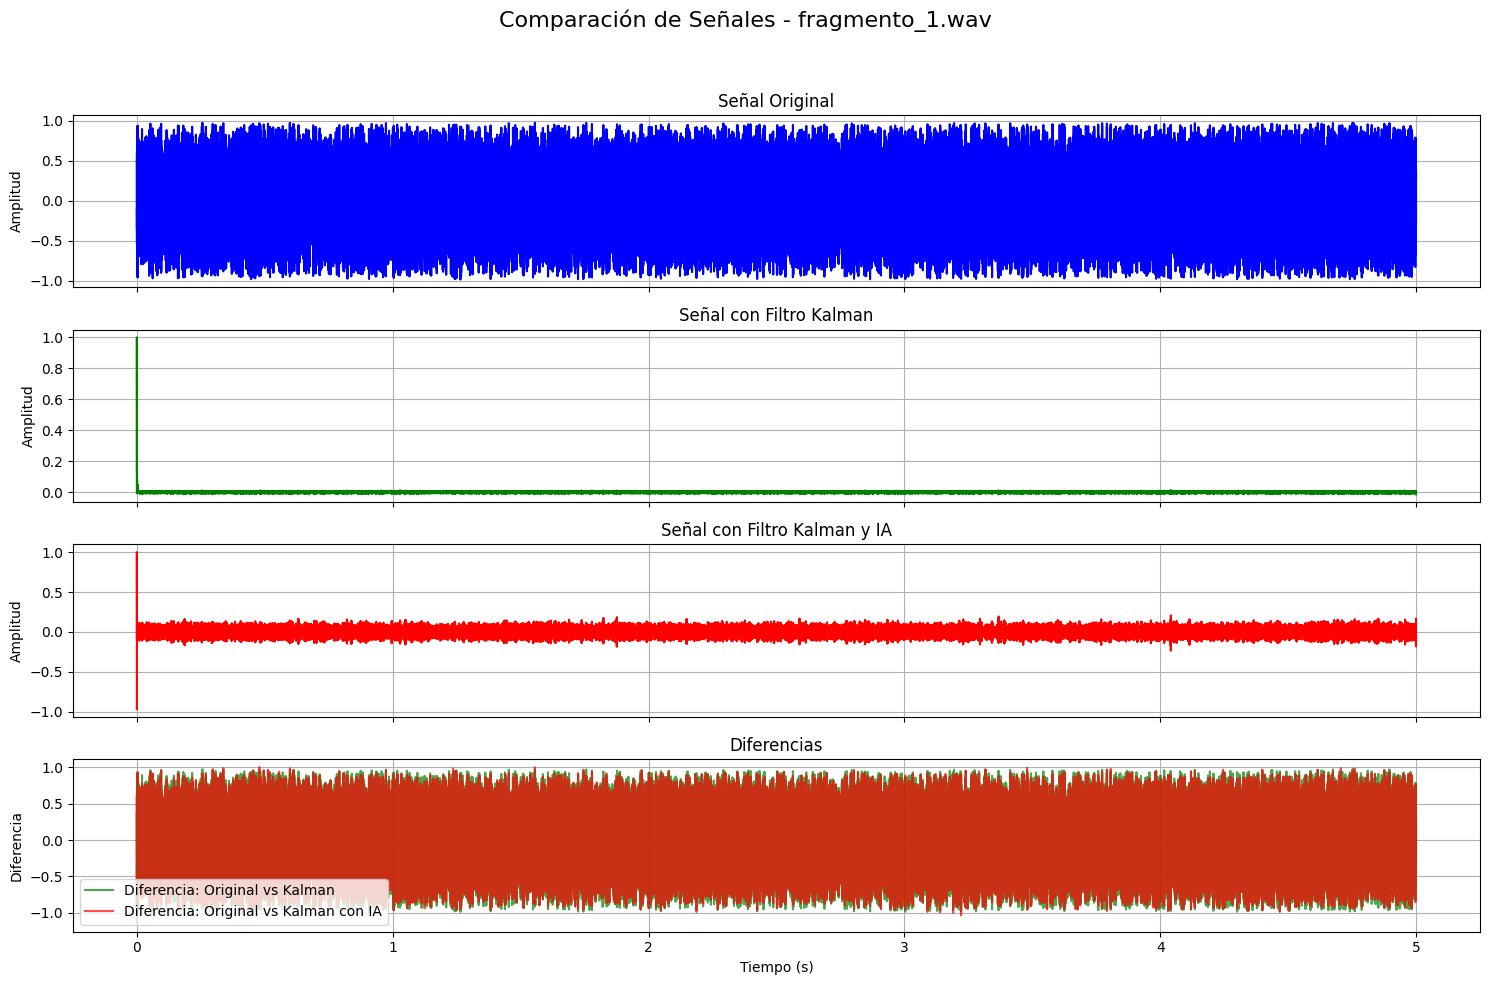

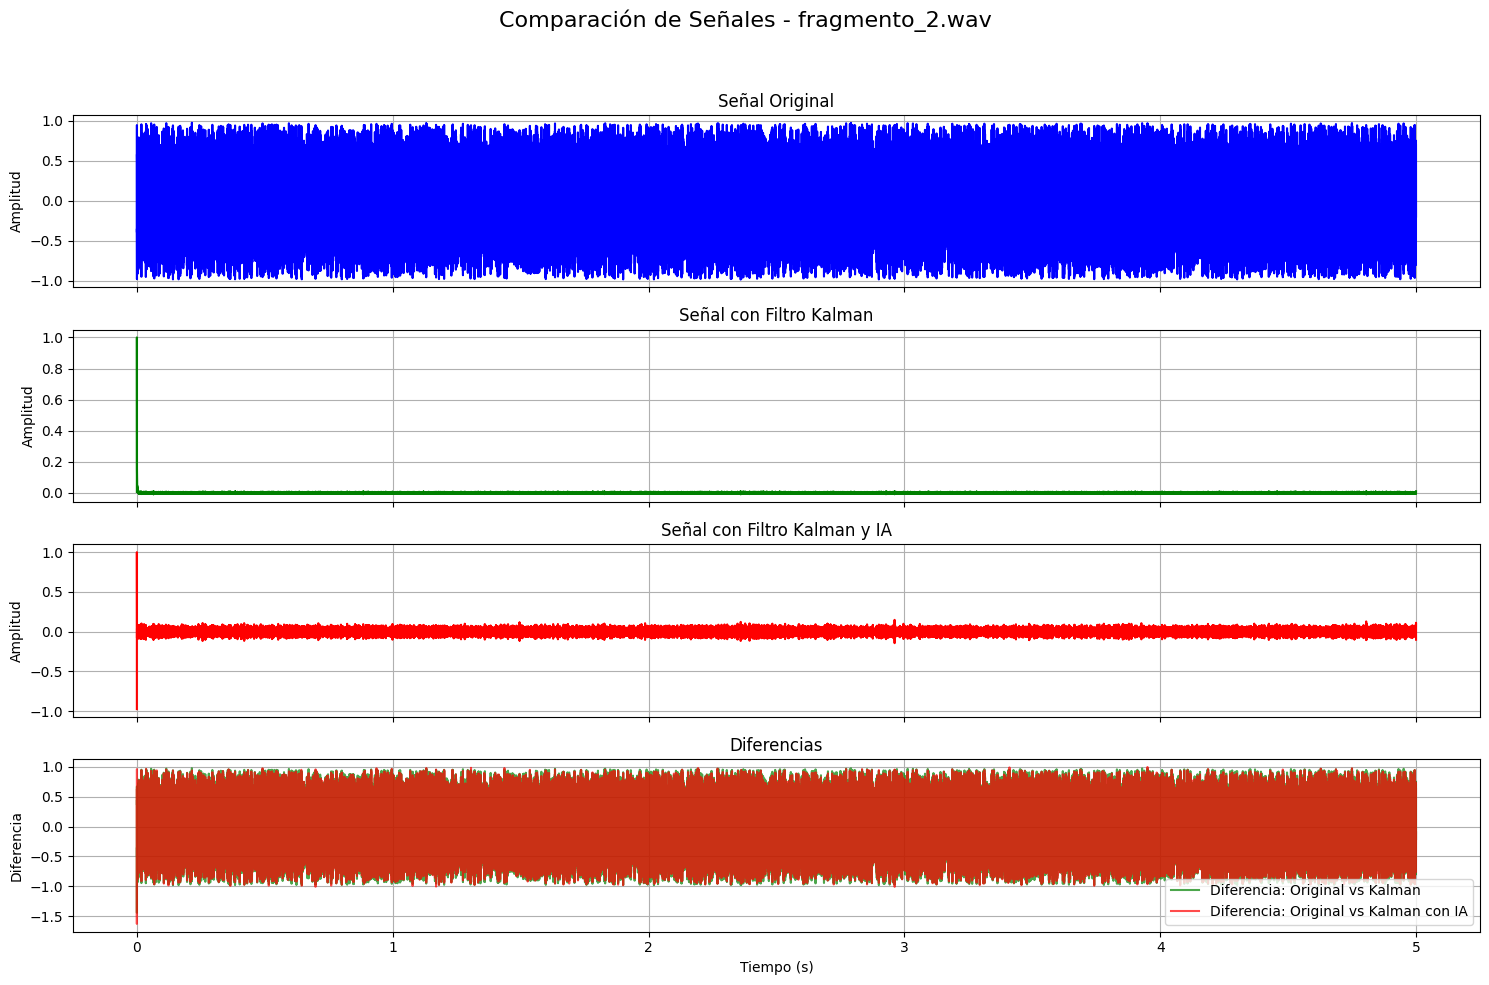

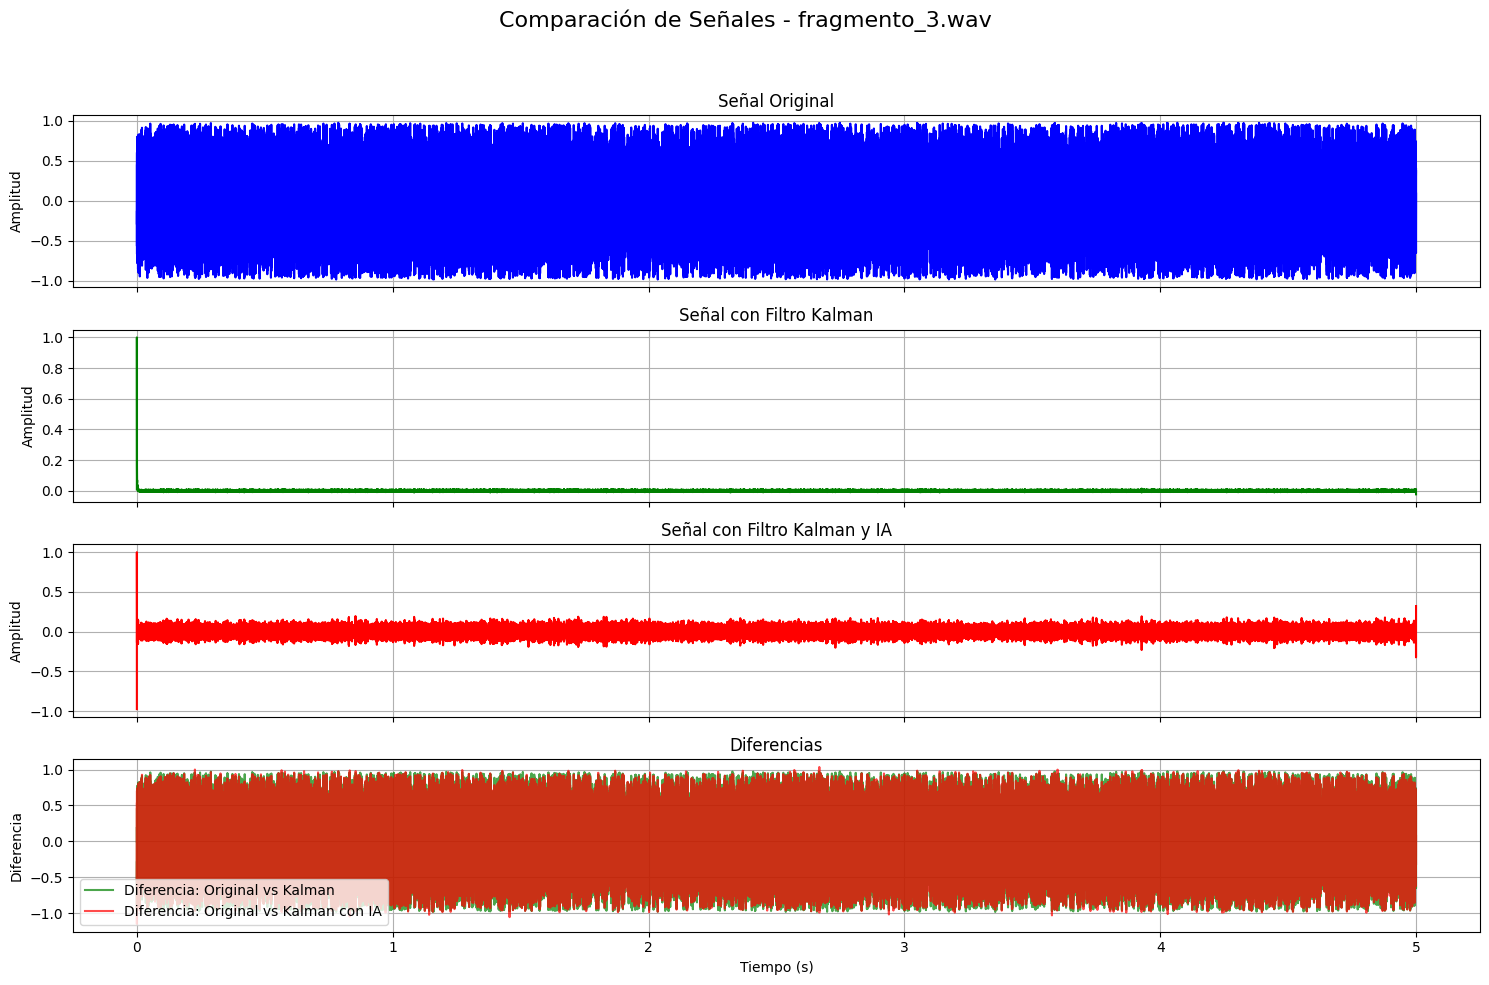

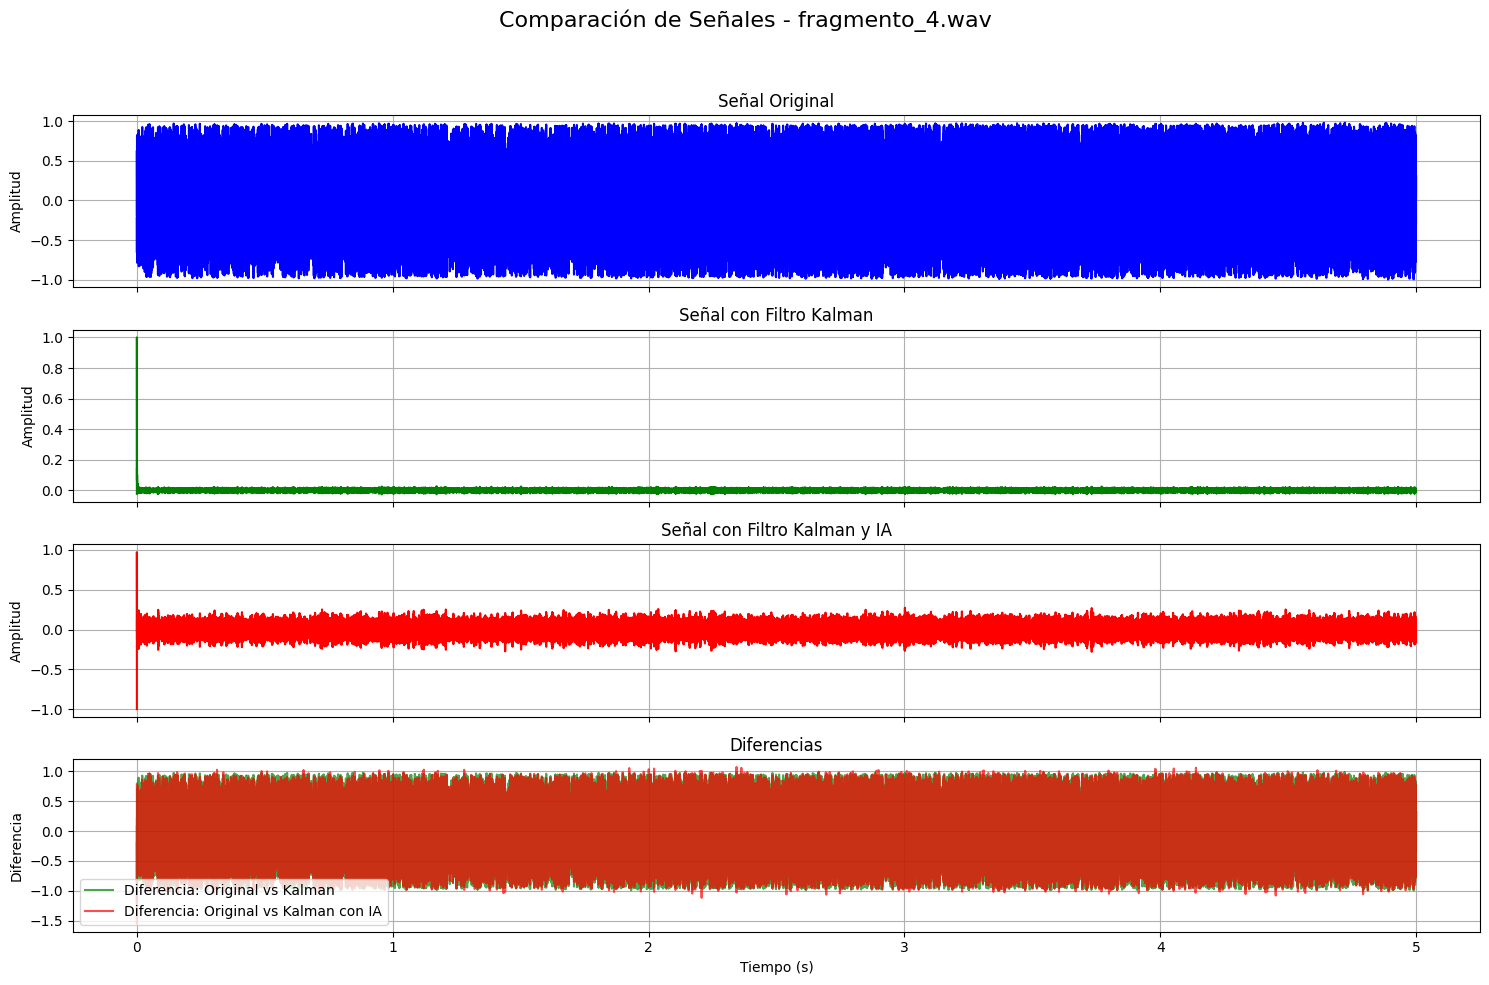

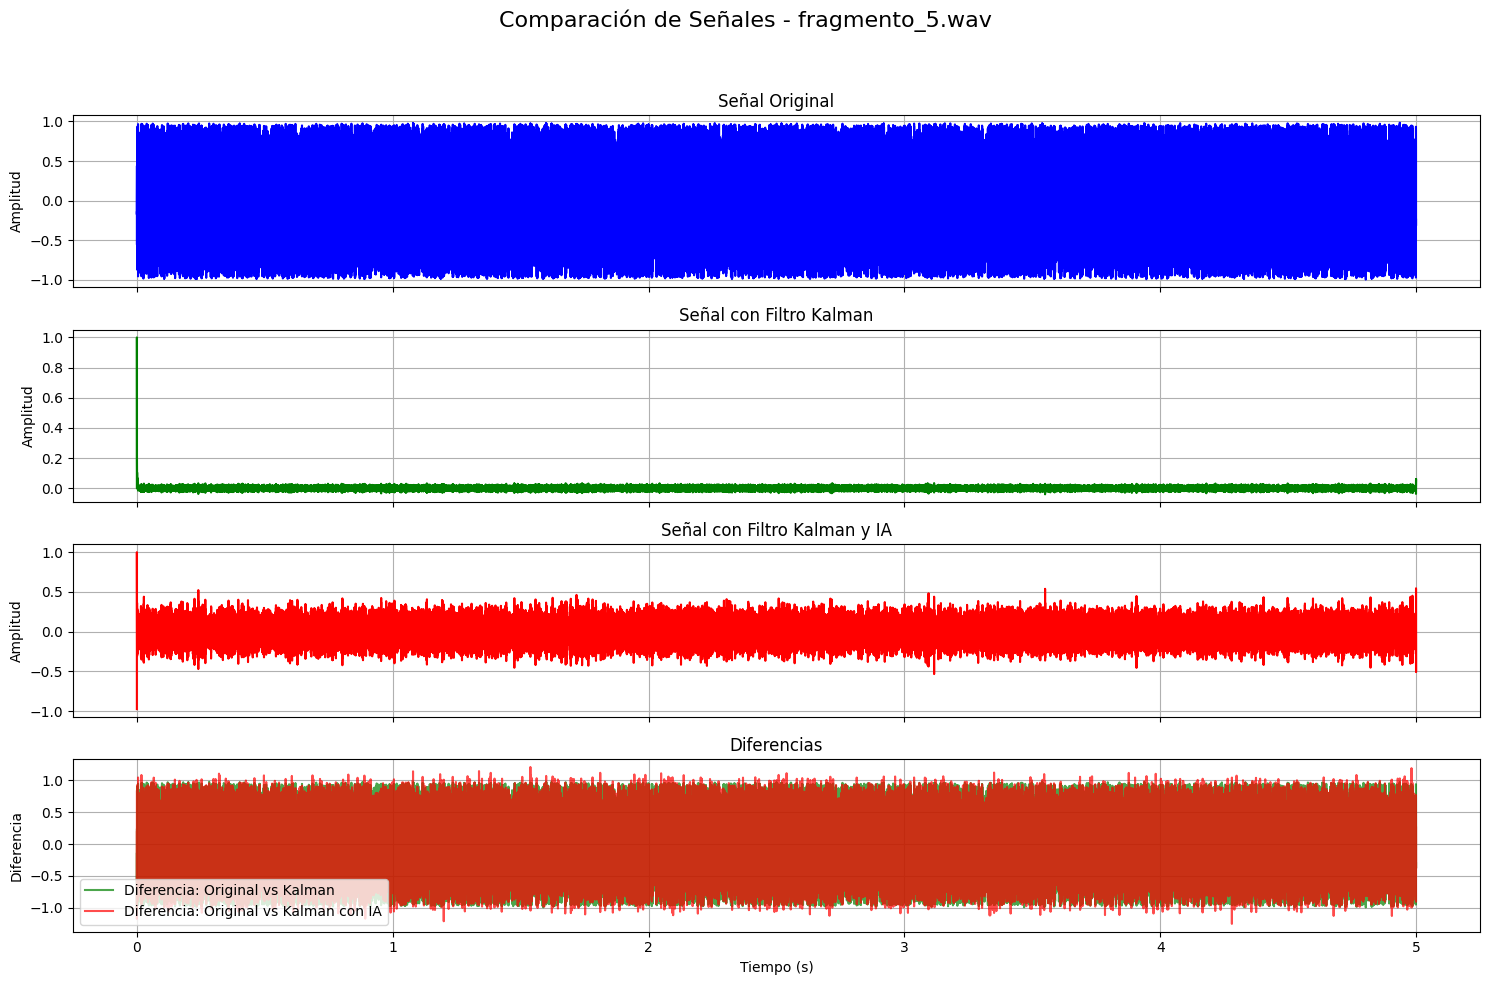

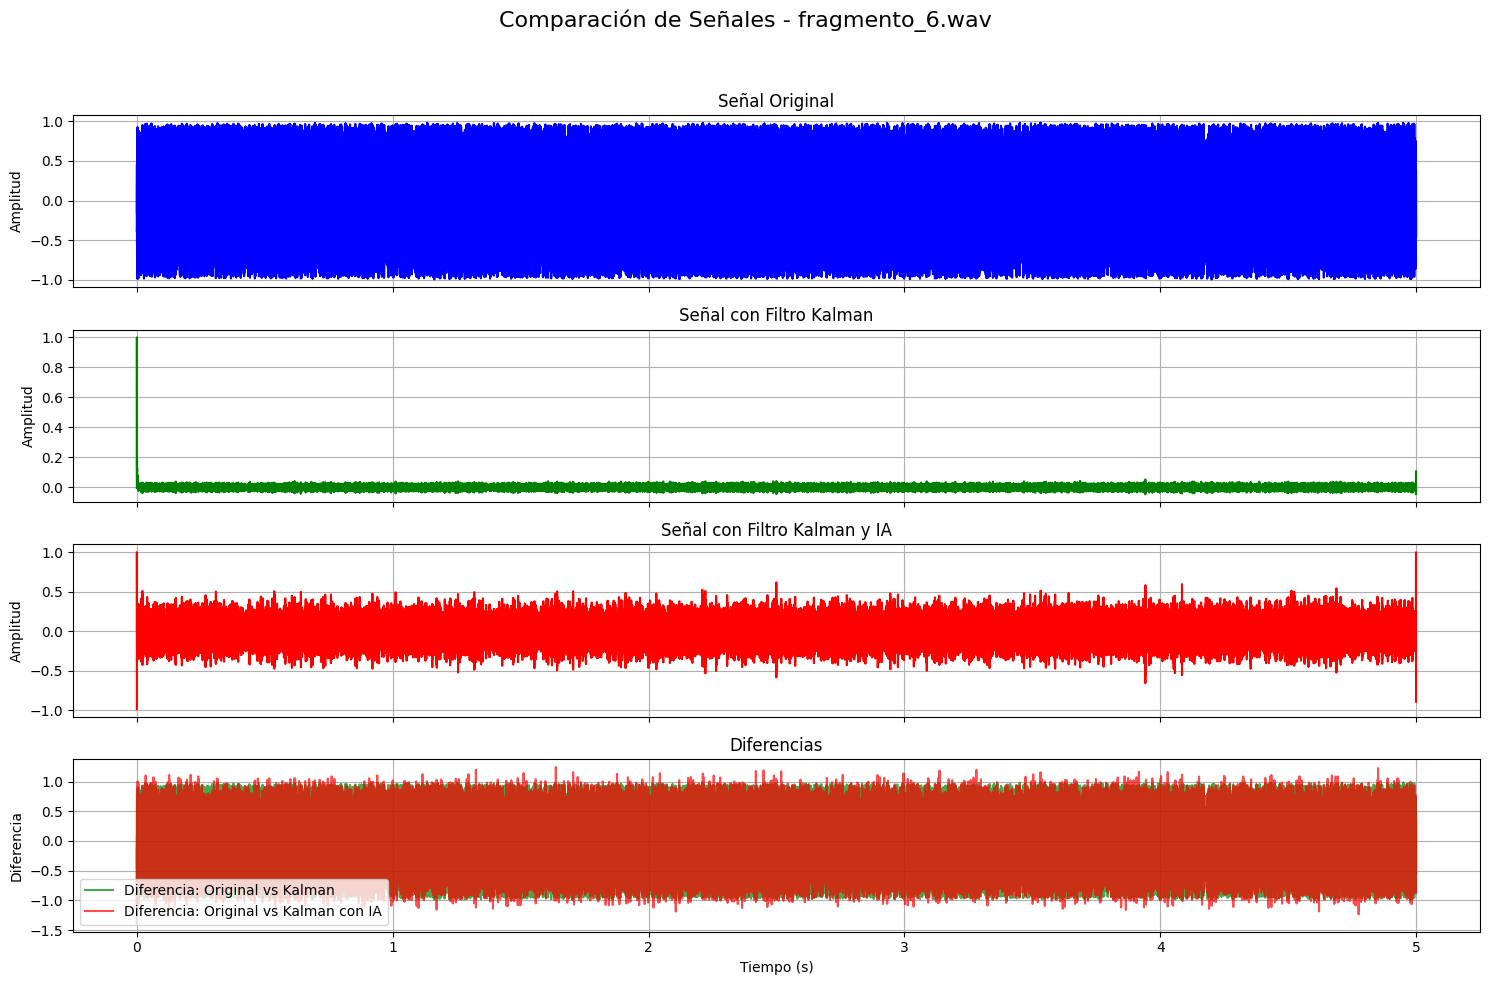

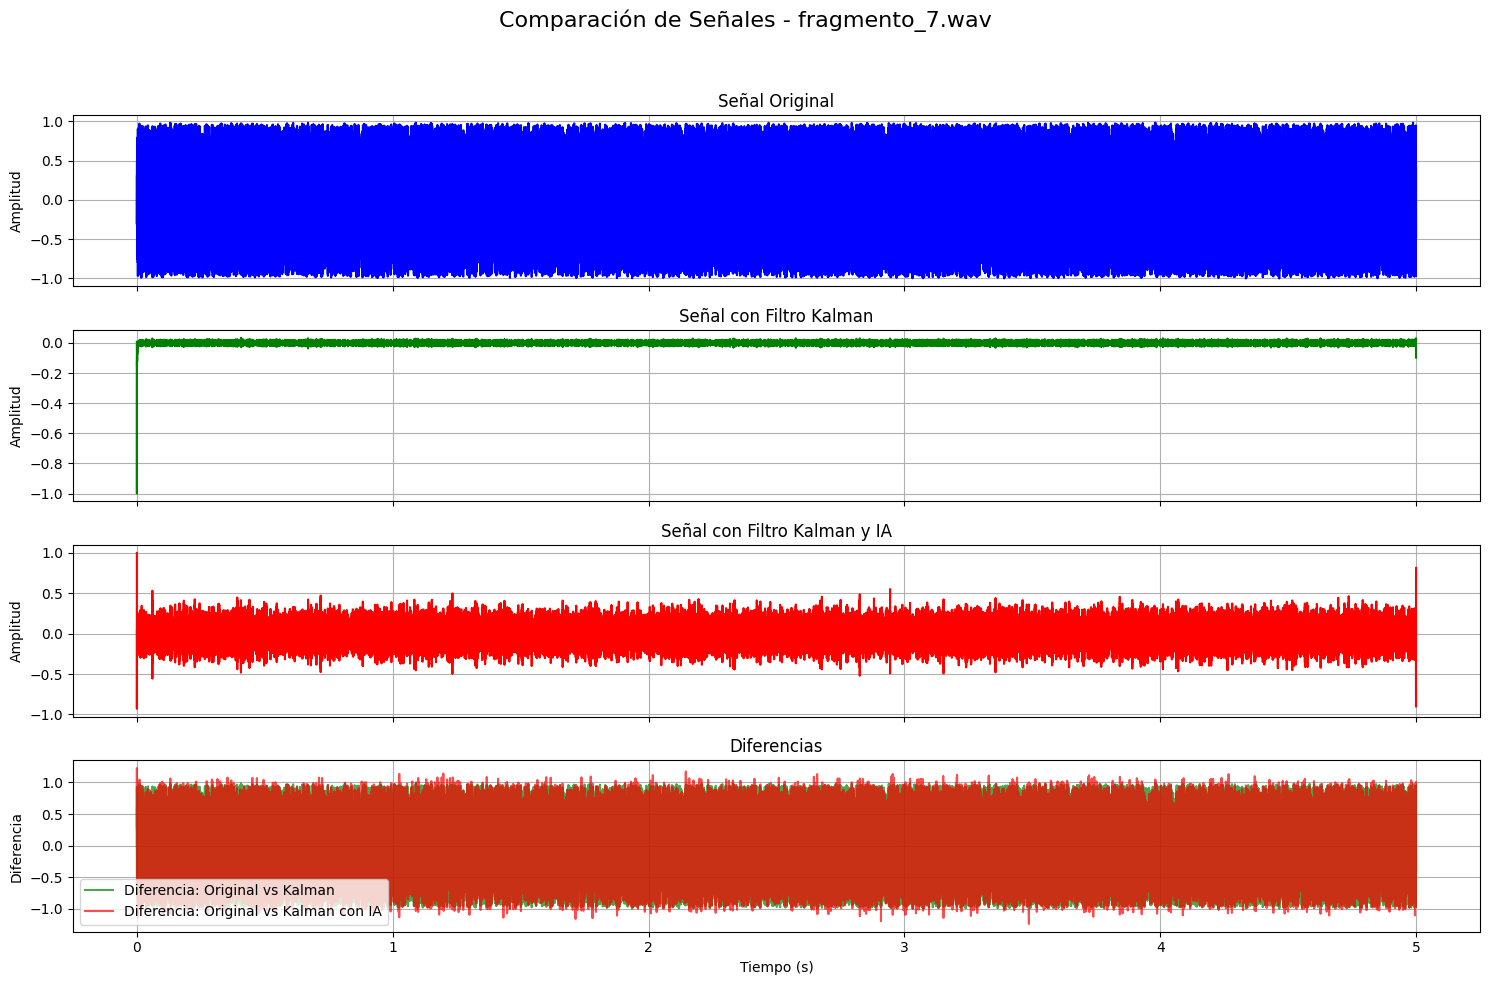

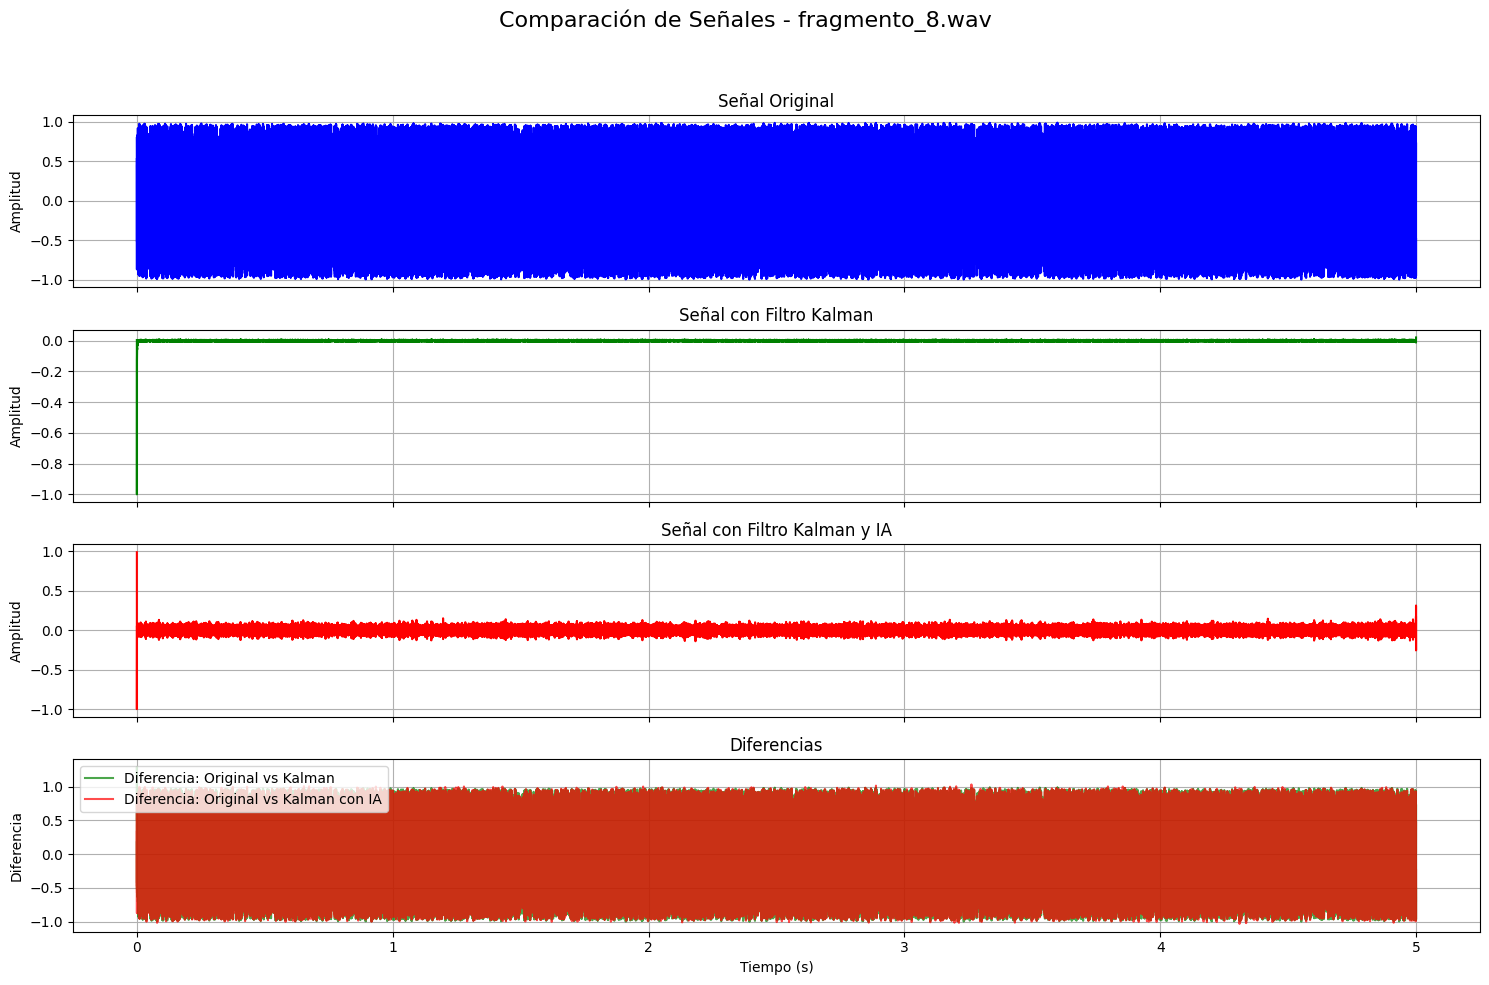

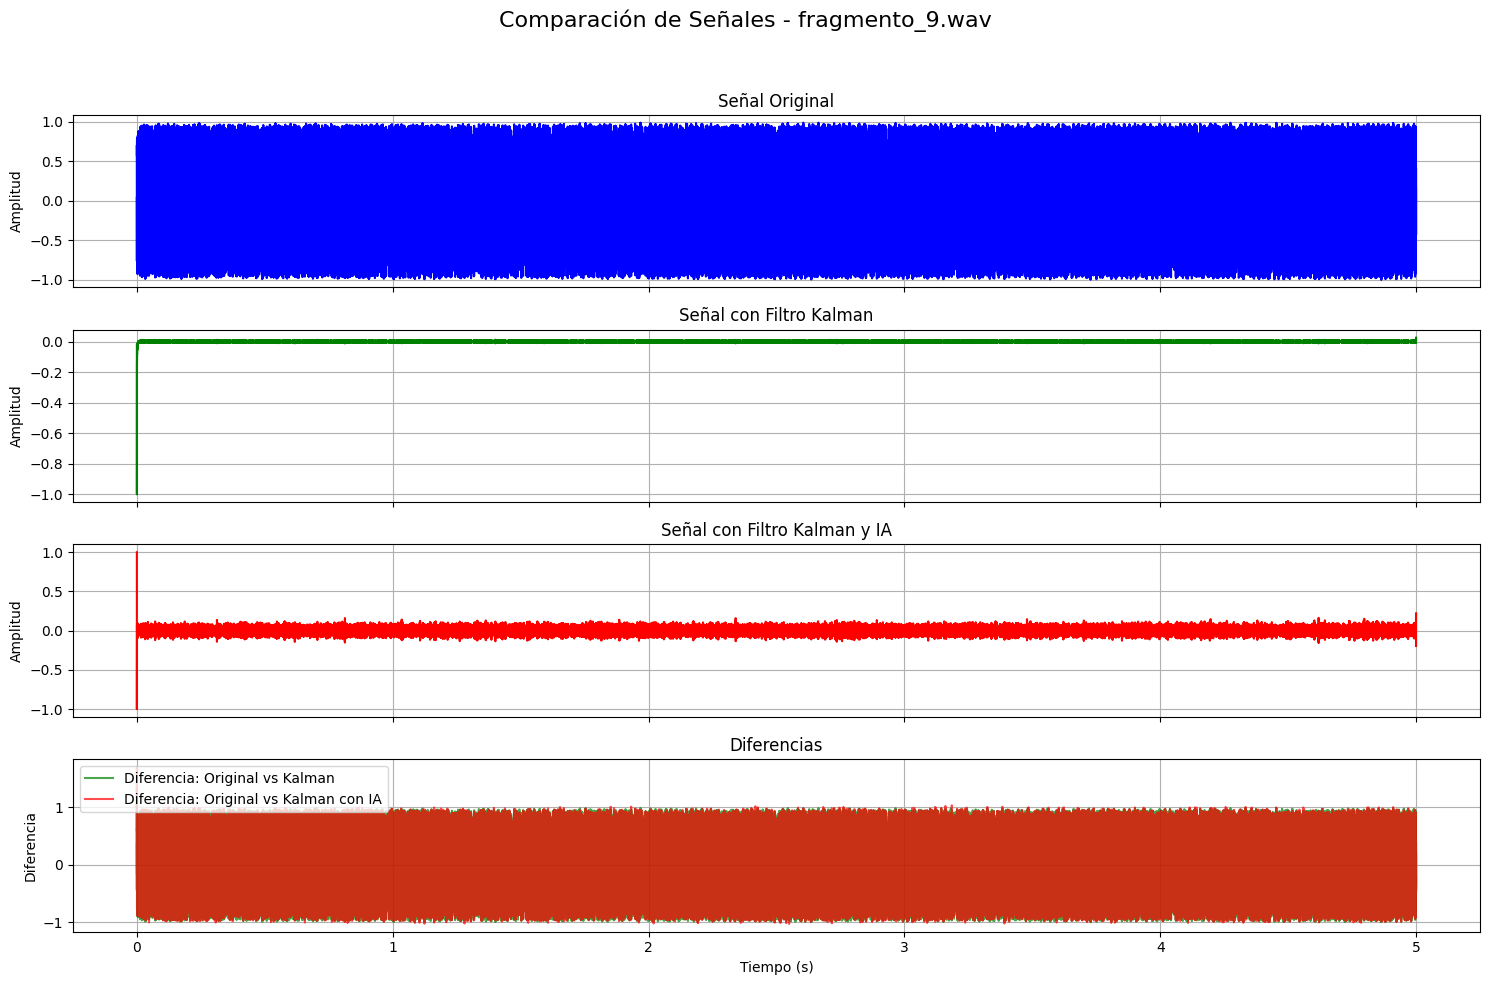

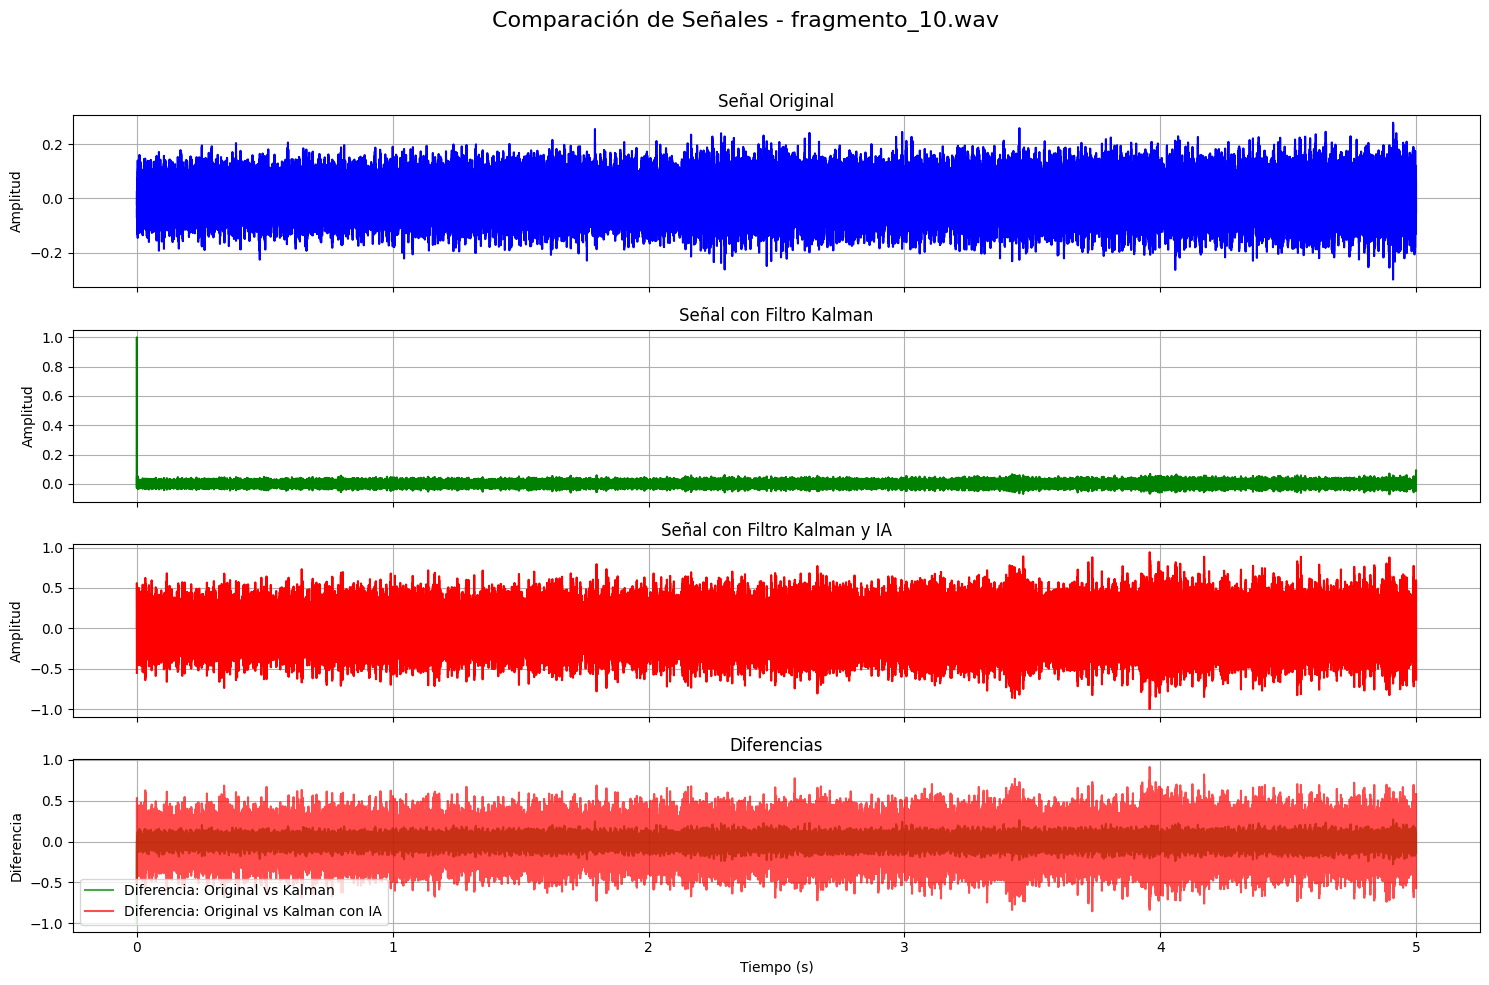


¡Proceso completado para los primeros 10 archivos!


In [27]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np

# Rutas de las carpetas
ruta_originales = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos"
ruta_kalman = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados"
ruta_kalman_ia = r"C:\Users\JOINER PEREZ\Pictures\mejorados"

# Obtener los primeros 10 archivos
n_archivos = 10
archivos = [f"fragmento_{i}.wav" for i in range(1, n_archivos + 1)]

# Función para graficar comparaciones separadas en un solo gráfico
def graficar_comparacion_separada(audio_original, audio_kalman, audio_kalman_ia, sr, nombre_archivo):
    """
    Genera gráficos separados en un solo gráfico para comparar señales originales, Kalman y Kalman con IA.
    """
    tiempo = np.linspace(0, len(audio_original) / sr, num=len(audio_original))

    # Calcular diferencias
    diferencia_kalman = audio_original - audio_kalman
    diferencia_kalman_ia = audio_original - audio_kalman_ia

    # Crear figura
    fig, axs = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

    # Señal original
    axs[0].plot(tiempo, audio_original, label="Original", color="blue")
    axs[0].set_title("Señal Original")
    axs[0].set_ylabel("Amplitud")
    axs[0].grid()

    # Señal Kalman
    axs[1].plot(tiempo, audio_kalman, label="Kalman", color="green")
    axs[1].set_title("Señal con Filtro Kalman")
    axs[1].set_ylabel("Amplitud")
    axs[1].grid()

    # Señal Kalman con IA
    axs[2].plot(tiempo, audio_kalman_ia, label="Kalman con IA", color="red")
    axs[2].set_title("Señal con Filtro Kalman y IA")
    axs[2].set_ylabel("Amplitud")
    axs[2].grid()

    # Diferencias
    axs[3].plot(tiempo, diferencia_kalman, label="Diferencia: Original vs Kalman", color="green", alpha=0.7)
    axs[3].plot(tiempo, diferencia_kalman_ia, label="Diferencia: Original vs Kalman con IA", color="red", alpha=0.7)
    axs[3].set_title("Diferencias")
    axs[3].set_xlabel("Tiempo (s)")
    axs[3].set_ylabel("Diferencia")
    axs[3].grid()
    axs[3].legend()

    # Configurar y guardar
    fig.suptitle(f"Comparación de Señales - {nombre_archivo}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"comparacion_separada_{nombre_archivo}.png")
    plt.show()

# Procesar y graficar los primeros archivos
for archivo in archivos:
    try:
        # Rutas de los audios
        ruta_original = os.path.join(ruta_originales, archivo)
        ruta_kalman_proc = os.path.join(ruta_kalman, archivo)
        ruta_kalman_ia_proc = os.path.join(ruta_kalman_ia, archivo)

        # Verificar existencia de los archivos
        if not os.path.exists(ruta_original):
            print(f"⚠ No se encontró el archivo original: {ruta_original}")
            continue
        if not os.path.exists(ruta_kalman_proc):
            print(f"⚠ No se encontró el archivo Kalman: {ruta_kalman_proc}")
            continue
        if not os.path.exists(ruta_kalman_ia_proc):
            print(f"⚠ No se encontró el archivo Kalman con IA: {ruta_kalman_ia_proc}")
            continue

        # Cargar audios
        audio_original, sr_original = librosa.load(ruta_original, sr=None, mono=True)
        audio_kalman, _ = librosa.load(ruta_kalman_proc, sr=sr_original, mono=True)
        audio_kalman_ia, _ = librosa.load(ruta_kalman_ia_proc, sr=sr_original, mono=True)

        # Graficar comparaciones separadas
        graficar_comparacion_separada(audio_original, audio_kalman, audio_kalman_ia, sr_original, archivo)

    except Exception as e:
        print(f"⚠ Error al procesar '{archivo}': {e}")

print("\n¡Proceso completado para los primeros 10 archivos!")


In [53]:
import os
import subprocess
import pandas as pd

# Rutas de los audios
audios_kalman = "C:/Users/JOINER PEREZ/Desktop/kal/con ia/mejorados"
audios_kalman_ia = "C:/Users/JOINER PEREZ/Pictures/mejorados"

# Ruta del directorio de BirdNET (cambia esto según tu instalación)
birdnet_path = "C:/ruta/a/BirdNET-Analyzer"

# Coordenadas de la región del Cesar, Colombia
lat, lon = 10.45, -73.25  # Ajusta si es necesario

# Función para procesar los audios con BirdNET
def clasificar_aves(audio_folder):
    archivos = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]
    
    if not archivos:
        print(f"⚠ No hay archivos .wav en {audio_folder}")
        return
    
    for archivo in archivos[:10]:  # Tomar los primeros 10 audios
        ruta_audio = os.path.join(audio_folder, archivo)
        output_file = os.path.join(audio_folder, archivo.replace(".wav", ".BirdNET.results.csv"))
        
        comando = [
            "python", os.path.join(birdnet_path, "analyze.py"),
            "--i", ruta_audio,
            "--o", audio_folder,
            "--lat", str(lat),
            "--lon", str(lon),
            "--min_conf", "0.5",  # Ajusta la confianza mínima
            "--rtype", "csv"      # Asegurar salida en CSV
        ]
        
        print(f"🔍 Procesando: {archivo} ...")
        subprocess.run(comando, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        # Verificar si el archivo CSV se generó
        if os.path.exists(output_file):
            print(f"✅ Resultados guardados en: {output_file}")
            
            # Leer el CSV y mostrar los primeros resultados
            df = pd.read_csv(output_file)
            print(df.head())
        else:
            print(f"⚠ No se generó el archivo de salida para {archivo}")

# Ejecutar clasificación en ambas carpetas
clasificar_aves(audios_kalman)
clasificar_aves(audios_kalman_ia)



🔍 Procesando: fragmento_1.wav ...
⚠ No se generó el archivo de salida para fragmento_1.wav
🔍 Procesando: fragmento_10.wav ...
⚠ No se generó el archivo de salida para fragmento_10.wav
🔍 Procesando: fragmento_100.wav ...
⚠ No se generó el archivo de salida para fragmento_100.wav
🔍 Procesando: fragmento_1009.wav ...
⚠ No se generó el archivo de salida para fragmento_1009.wav
🔍 Procesando: fragmento_101.wav ...
⚠ No se generó el archivo de salida para fragmento_101.wav
🔍 Procesando: fragmento_1017.wav ...
⚠ No se generó el archivo de salida para fragmento_1017.wav
🔍 Procesando: fragmento_1019.wav ...
⚠ No se generó el archivo de salida para fragmento_1019.wav
🔍 Procesando: fragmento_102.wav ...
⚠ No se generó el archivo de salida para fragmento_102.wav
🔍 Procesando: fragmento_1020.wav ...
⚠ No se generó el archivo de salida para fragmento_1020.wav
🔍 Procesando: fragmento_1021.wav ...
⚠ No se generó el archivo de salida para fragmento_1021.wav
🔍 Procesando: fragmento_1.wav ...
⚠ No se gene

In [13]:
import os
import pandas as pd
from openpyxl import Workbook
from openpyxl.drawing.image import Image

input_folder = r"C:\Users\JOINER PEREZ\Pictures\mejorados\resultados"
output_file = r"C:\Users\JOINER PEREZ\Pictures\mejorados\resultados_completos_con_kalmanIA.xlsx"

# Diccionario para renombrar las columnas a español
column_renames = {
    "Common name": "Nombre común",
    "Scientific name": "Nombre científico",
    "Confidence": "Confianza",
    "Start time": "Hora de inicio",
    "End time": "Hora de fin",
    "File name": "Nombre del archivo"
}

# Lista para almacenar los resultados
all_results = []

# Itera sobre los archivos CSV en la carpeta de resultados
for file_name in os.listdir(input_folder):
    if file_name.endswith(".csv"):  # Asegúrate de que sea un archivo CSV
        file_path = os.path.join(input_folder, file_name)
        
        # Lee el archivo CSV con los resultados
        df = pd.read_csv(file_path)
        
        # Renombra las columnas a español
        df = df.rename(columns=column_renames)
        
        # Agrega la columna con el nombre del archivo de audio
        df['Nombre del archivo'] = file_name
        
        # Filtra columnas vacías o con solo valores NA
        df = df.dropna(axis=1, how='all')
        
        # Añade los resultados al DataFrame general
        all_results.append(df)

# Combina todos los DataFrames en uno solo
final_df = pd.concat(all_results, ignore_index=True)

# Crea el archivo Excel
wb = Workbook()
ws = wb.active
ws.title = "Resultados"

# Añade los encabezados de las columnas
for col_num, column_name in enumerate(final_df.columns, 1):
    ws.cell(row=1, column=col_num, value=column_name)

# Añade los datos al archivo Excel
for row_num, row in enumerate(final_df.itertuples(index=False), 2):
    for col_num, value in enumerate(row, 1):
        ws.cell(row=row_num, column=col_num, value=value)

    # Obtener el nombre común de la especie y buscar la imagen correspondiente
    species_name = row[final_df.columns.get_loc('Nombre común')]
    image_path = os.path.join(image_folder, f"{species_name}.jpg")

    # Si la imagen existe, la añadimos
    if os.path.exists(image_path):
        img = Image(image_path)
        img.anchor = f'G{row_num}'  # Cambia 'G' si deseas la imagen en otra columna
        ws.add_image(img)

# Guarda el archivo Excel con las imágenes
wb.save(output_file)

print(f"Resultados con imágenes guardados en {output_file}")


Resultados con imágenes guardados en C:\Users\JOINER PEREZ\Pictures\mejorados\resultados_completos_con_kalmanIA.xlsx


In [14]:
import os
import pandas as pd
from openpyxl import Workbook
from openpyxl.drawing.image import Image

# Definir rutas de entrada y salida
input_folder = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\ultima carpeta\resultados"  # Carpeta con CSVs
image_folder = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\imagenes"  # Carpeta con imágenes
output_file = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\ultima carpeta\resultados_completos_kalman.xlsx"

# Diccionario para renombrar las columnas a español
column_renames = {
    "Common name": "Nombre común",
    "Scientific name": "Nombre científico",
    "Confidence": "Confianza",
    "Start time": "Hora de inicio",
    "End time": "Hora de fin",
    "File name": "Nombre del archivo"
}

# Lista para almacenar los resultados
all_results = []

# Verificar si la carpeta de resultados existe
if not os.path.exists(input_folder):
    print(f"Error: La carpeta '{input_folder}' no existe.")
else:
    # Iterar sobre los archivos CSV en la carpeta de resultados
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".csv"):  # Asegurar que sea un archivo CSV
            file_path = os.path.join(input_folder, file_name)
            
            # Leer el archivo CSV con los resultados
            df = pd.read_csv(file_path)
            
            # Renombrar las columnas a español
            df = df.rename(columns=column_renames)
            
            # Agregar la columna con el nombre del archivo de audio
            df['Nombre del archivo'] = file_name
            
            # Filtrar columnas vacías o con solo valores NA
            df = df.dropna(axis=1, how='all')
            
            # Añadir los resultados a la lista
            all_results.append(df)

    # Verificar si hay datos para combinar
    if all_results:
        # Combinar todos los DataFrames en uno solo
        final_df = pd.concat(all_results, ignore_index=True)

        # Crear el archivo Excel
        wb = Workbook()
        ws = wb.active
        ws.title = "Resultados"

        # Añadir los encabezados de las columnas
        for col_num, column_name in enumerate(final_df.columns, 1):
            ws.cell(row=1, column=col_num, value=column_name)

        # Añadir los datos al archivo Excel
        for row_num, row in enumerate(final_df.itertuples(index=False), 2):
            for col_num, value in enumerate(row, 1):
                ws.cell(row=row_num, column=col_num, value=value)

            # Obtener el nombre común de la especie y buscar la imagen correspondiente
            species_name = row[final_df.columns.get_loc('Nombre común')]
            image_path = os.path.join(image_folder, f"{species_name}.jpg")

            # Si la imagen existe, la añadimos
            if os.path.exists(image_path):
                img = Image(image_path)
                img.anchor = f'G{row_num}'  # Cambia 'G' si deseas la imagen en otra columna
                ws.add_image(img)

        # Guardar el archivo Excel con las imágenes
        wb.save(output_file)

        print(f"✅ Resultados con imágenes guardados en: {output_file}")
    else:
        print("⚠️ No se encontraron archivos CSV en la carpeta especificada.")


✅ Resultados con imágenes guardados en: C:\Users\JOINER PEREZ\Desktop\kal\con ia\ultima carpeta\resultados_completos_kalman.xlsx


In [15]:
import os
import pandas as pd
from openpyxl import Workbook
from openpyxl.drawing.image import Image

# Definir rutas de entrada y salida
input_folder = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos seleccionados\resultados"  # Carpeta con CSVs
image_folder = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\imagenes"  # Carpeta con imágenes
output_file = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos seleccionados\resultados_completos_sin_nada.xlsx"

# Diccionario para renombrar las columnas a español
column_renames = {
    "Common name": "Nombre común",
    "Scientific name": "Nombre científico",
    "Confidence": "Confianza",
    "Start time": "Hora de inicio",
    "End time": "Hora de fin",
    "File name": "Nombre del archivo"
}

# Lista para almacenar los resultados
all_results = []

# Verificar si la carpeta de resultados existe
if not os.path.exists(input_folder):
    print(f"Error: La carpeta '{input_folder}' no existe.")
else:
    # Iterar sobre los archivos CSV en la carpeta de resultados
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".csv"):  # Asegurar que sea un archivo CSV
            file_path = os.path.join(input_folder, file_name)
            
            # Leer el archivo CSV con los resultados
            df = pd.read_csv(file_path)
            
            # Renombrar las columnas a español
            df = df.rename(columns=column_renames)
            
            # Agregar la columna con el nombre del archivo de audio
            df['Nombre del archivo'] = file_name
            
            # Filtrar columnas vacías o con solo valores NA
            df = df.dropna(axis=1, how='all')
            
            # Añadir los resultados a la lista
            all_results.append(df)

    # Verificar si hay datos para combinar
    if all_results:
        # Combinar todos los DataFrames en uno solo
        final_df = pd.concat(all_results, ignore_index=True)

        # Crear el archivo Excel
        wb = Workbook()
        ws = wb.active
        ws.title = "Resultados"

        # Añadir los encabezados de las columnas
        for col_num, column_name in enumerate(final_df.columns, 1):
            ws.cell(row=1, column=col_num, value=column_name)

        # Añadir los datos al archivo Excel
        for row_num, row in enumerate(final_df.itertuples(index=False), 2):
            for col_num, value in enumerate(row, 1):
                ws.cell(row=row_num, column=col_num, value=value)

            # Obtener el nombre común de la especie y buscar la imagen correspondiente
            species_name = row[final_df.columns.get_loc('Nombre común')]
            image_path = os.path.join(image_folder, f"{species_name}.jpg")

            # Si la imagen existe, la añadimos
            if os.path.exists(image_path):
                img = Image(image_path)
                img.anchor = f'G{row_num}'  # Cambia 'G' si deseas la imagen en otra columna
                ws.add_image(img)

        # Guardar el archivo Excel con las imágenes
        wb.save(output_file)

        print(f"✅ Resultados con imágenes guardados en: {output_file}")
    else:
        print("⚠️ No se encontraron archivos CSV en la carpeta especificada.")

✅ Resultados con imágenes guardados en: C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos seleccionados\resultados_completos_sin_nada.xlsx


In [16]:
import os
import pandas as pd
from openpyxl import Workbook
from openpyxl.drawing.image import Image

# Definir rutas de entrada y salida
input_folder = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos\resultados"  # Carpeta con CSVs
image_folder = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\imagenes"  # Carpeta con imágenes
output_file = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos\resultados_completos_sin_nada2.xlsx"

# Diccionario para renombrar las columnas a español
column_renames = {
    "Common name": "Nombre común",
    "Scientific name": "Nombre científico",
    "Confidence": "Confianza",
    "Start time": "Hora de inicio",
    "End time": "Hora de fin",
    "File name": "Nombre del archivo"
}

# Lista para almacenar los resultados
all_results = []

# Verificar si la carpeta de resultados existe
if not os.path.exists(input_folder):
    print(f"Error: La carpeta '{input_folder}' no existe.")
else:
    # Iterar sobre los archivos CSV en la carpeta de resultados
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".csv"):  # Asegurar que sea un archivo CSV
            file_path = os.path.join(input_folder, file_name)
            
            # Leer el archivo CSV con los resultados
            df = pd.read_csv(file_path)
            
            # Renombrar las columnas a español
            df = df.rename(columns=column_renames)
            
            # Agregar la columna con el nombre del archivo de audio
            df['Nombre del archivo'] = file_name
            
            # Filtrar columnas vacías o con solo valores NA
            df = df.dropna(axis=1, how='all')
            
            # Añadir los resultados a la lista
            all_results.append(df)

    # Verificar si hay datos para combinar
    if all_results:
        # Combinar todos los DataFrames en uno solo
        final_df = pd.concat(all_results, ignore_index=True)

        # Crear el archivo Excel
        wb = Workbook()
        ws = wb.active
        ws.title = "Resultados"

        # Añadir los encabezados de las columnas
        for col_num, column_name in enumerate(final_df.columns, 1):
            ws.cell(row=1, column=col_num, value=column_name)

        # Añadir los datos al archivo Excel
        for row_num, row in enumerate(final_df.itertuples(index=False), 2):
            for col_num, value in enumerate(row, 1):
                ws.cell(row=row_num, column=col_num, value=value)

            # Obtener el nombre común de la especie y buscar la imagen correspondiente
            species_name = row[final_df.columns.get_loc('Nombre común')]
            image_path = os.path.join(image_folder, f"{species_name}.jpg")

            # Si la imagen existe, la añadimos
            if os.path.exists(image_path):
                img = Image(image_path)
                img.anchor = f'G{row_num}'  # Cambia 'G' si deseas la imagen en otra columna
                ws.add_image(img)

        # Guardar el archivo Excel con las imágenes
        wb.save(output_file)

        print(f"✅ Resultados con imágenes guardados en: {output_file}")
    else:
        print("⚠️ No se encontraron archivos CSV en la carpeta especificada.")


✅ Resultados con imágenes guardados en: C:\Users\JOINER PEREZ\Desktop\kal\con ia\fragmentos\resultados_completos_sin_nada2.xlsx


In [21]:
import os
import pandas as pd
from openpyxl import Workbook
from openpyxl.drawing.image import Image

# Definir rutas de entrada y salida
input_folder = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados\resultados"  # Carpeta con CSVs
image_folder = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\imagenes"  # Carpeta con imágenes
output_file = r"C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados\resultados_completos_kalman2.xlsx"

# Diccionario para renombrar las columnas a español
column_renames = {
    "Common name": "Nombre común",
    "Scientific name": "Nombre científico",
    "Confidence": "Confianza",
    "Start time": "Hora de inicio",
    "End time": "Hora de fin",
    "File name": "Nombre del archivo"
}

# Lista para almacenar los resultados
all_results = []

# Verificar si la carpeta de resultados existe
if not os.path.exists(input_folder):
    print(f"Error: La carpeta '{input_folder}' no existe.")
else:
    # Iterar sobre los archivos CSV en la carpeta de resultados
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".csv"):  # Asegurar que sea un archivo CSV
            file_path = os.path.join(input_folder, file_name)
            
            # Leer el archivo CSV con los resultados
            df = pd.read_csv(file_path)
            
            # Renombrar las columnas a español
            df = df.rename(columns=column_renames)
            
            # Agregar la columna con el nombre del archivo de audio
            df['Nombre del archivo'] = file_name
            
            # Filtrar columnas vacías o con solo valores NA
            df = df.dropna(axis=1, how='all')
            
            # Añadir los resultados a la lista
            all_results.append(df)

    # Verificar si hay datos para combinar
    if all_results:
        # Combinar todos los DataFrames en uno solo
        final_df = pd.concat(all_results, ignore_index=True)

        # Crear el archivo Excel
        wb = Workbook()
        ws = wb.active
        ws.title = "Resultados"

        # Añadir los encabezados de las columnas
        for col_num, column_name in enumerate(final_df.columns, 1):
            ws.cell(row=1, column=col_num, value=column_name)

        # Añadir los datos al archivo Excel
        for row_num, row in enumerate(final_df.itertuples(index=False), 2):
            for col_num, value in enumerate(row, 1):
                ws.cell(row=row_num, column=col_num, value=value)

            # Obtener el nombre de la especie desde el nombre del archivo (sin la extensión)
            species_name = os.path.splitext(row[final_df.columns.get_loc('Nombre del archivo')])[0]

            # Crear la ruta de la imagen
            image_path = os.path.join(image_folder, f"{species_name}.jpg")

            # Si la imagen existe, la añadimos
            if os.path.exists(image_path):
                img = Image(image_path)
                img.anchor = f'G{row_num}'  # Cambia 'G' si deseas la imagen en otra columna
                ws.add_image(img)

        # Guardar el archivo Excel con las imágenes
        wb.save(output_file)

        print(f"✅ Resultados con imágenes guardados en: {output_file}")
    else:
        print("⚠️ No se encontraron archivos CSV en la carpeta especificada.")


✅ Resultados con imágenes guardados en: C:\Users\JOINER PEREZ\Desktop\kal\con ia\mejorados\resultados_completos_kalman2.xlsx


In [18]:
print(df.columns)


Index(['File splitting duration', 'Segment length', 'Sample rate',
       'Segment overlap', 'Minimum Segment length', 'Bandpass filter minimum',
       'Bandpass filter maximum', 'Audio speed', 'Nombre del archivo'],
      dtype='object')
